# Classification on Botnet DGA Dataset

In [12]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pennylane as qml
from pennylane import numpy as np

from datetime import datetime
import os
import pickle
import time

import qiskit
import qiskit.providers.aer.noise as noise

from qiskit import QuantumCircuit, execute
from qiskit import IBMQ, Aer
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel

In [13]:
#IBMQ.save_account('412323e770fb2ee81fb9b79d3effe940d0a7f72c3be198a65f580a20b38b00a607ad8c8a9b5322116fc1aee89be55463fe87e7a43da6af415bbaa95236fca521')

## Experiment Settings

In [14]:
import random as python_random
SEED = 123
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(SEED)
python_random.seed(SEED)
tf.random.set_seed(SEED)

n_qubits = 2
# dev = qml.device("default.mixed", wires=n_qubits)


#dev = qml.device('qiskit.aer', wires=n_qubits)


# Error probabilities
#prob_1 = 0.001  # 1-qubit gate
#prob_2 = 0.01   # 2-qubit gate

# Depolarizing quantum errors
#error_1 = noise.depolarizing_error(prob_1, 1)
#error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
#noise_model = noise.NoiseModel()
#noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
#noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# Create a PennyLane device
# dev = qml.device('qiskit.aer', wires=n_qubits, noise_model=noise_model)


# Build noise model from backend properties
provider = IBMQ.load_account()
backend = provider.get_backend('ibmqx2')
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

dev = qml.device('qiskit.aer', wires=n_qubits, backend='qasm_simulator', 
                 coupling_map=coupling_map, basis_gates=basis_gates, noise_model=noise_model)
#                 backend_options={"validation_threshold": 1e-6})


n_layers = 1 #6
num_data = 1000  #1803333
EPOCHS = 10000
BATCH_SIZE = 50 #2048


weight_shapes = {"weights": (n_layers, n_qubits)}

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

now = datetime.now()
results_folder = "RESULTS5-QiskitNoisy/nd1000_nq2_nl1_03-25-2021_14-03-25/"
#"RESULTS5-QiskitNoisy/nd" + str(num_data) + "_" + "nq" + str(n_qubits) + "_" + "nl" + str(n_layers) + "_" + now.strftime("%m-%d-%Y_%H-%M-%S") + "/"
print("results_folder: ",results_folder)
#os.mkdir(results_folder)

f = open(results_folder + "results.txt", "a", encoding='utf-8')
f.write(results_folder + "\n")

mpl.rcParams['savefig.dpi'] = 600

ibmqfactory.load_account:WARNING:2021-04-15 22:40:59,186: Credentials are already in use. The existing account in the session will be replaced.


results_folder:  RESULTS5-QiskitNoisy/nd1000_nq2_nl1_03-25-2021_14-03-25/


## Example of a QNode

In [15]:
@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

## Data processing and exploration

### Load csv data set

In [16]:
#raw_df = pd.read_csv("dataset/n"+str(num_data)+"_botnetdga_TRAIN.csv")
#raw_df.head()

In [17]:
#raw_df[['Entropy','REAlexa','MinREBotnets','InformationRadius','CharLength','TreeNewFeature','nGramReputation_Alexa','Class']].describe()

### Clean, split and normalize the data

In [18]:
#cleaned_df = raw_df.copy()
#cleaned_df.pop('Entropy')
#cleaned_df.pop('REAlexa')
#cleaned_df.pop('InformationRadius')

In [19]:
#train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
#train_df, val_df = train_test_split(train_df, test_size=0.2)

In [20]:
#train_labels = np.array(train_df.pop('Class'))
#val_labels = np.array(val_df.pop('Class'))
#test_labels = np.array(test_df.pop('Class'))

In [21]:
#train_features = np.array(train_df)
#val_features = np.array(val_df)
#test_features = np.array(test_df)

In [22]:
#scaler = StandardScaler()
#train_features = scaler.fit_transform(train_features)
#val_features = scaler.transform(val_features)
#test_features = scaler.transform(test_features)

In [23]:
#train_features = np.clip(train_features, -5, 5)
#val_features = np.clip(val_features, -5, 5)
#test_features = np.clip(test_features, -5, 5)

## Loads the already prepared benchmark datasets

In [24]:
test_features = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_test_features.csv") )
test_labels = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_test_labels.csv") )

train_features = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_train_features.csv") )
train_labels = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_train_labels.csv") )

val_features = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_val_features.csv") )
val_labels = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_val_labels.csv") )

## Define the model and metrics 

In [25]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          n_qubits, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      qlayer,
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [26]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=100,
    mode='max',
    restore_best_weights=True)

In [27]:
def plot_loss(history, label, n, expId):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.savefig(results_folder + '_' + str(expId) + '_plot_loss.png', format='png')

    
def plot_metrics(history, expId):
  metrics = ['accuracy', 'loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(5,1,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    plt.savefig(results_folder + '_' + str(expId) + '_plot_metrics.png', format='png')
    
def plot_cm(labels, predictions, expId , p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  plt.savefig(results_folder + '_' + str(expId) + '_plot_cm.png', format='png')

  print('Legitimate Domain Name Detected (True Negatives): ', cm[0][0])
  print('Legitimate Domain Name Incorrectly Detected as Botnet DGA (False Positives): ', cm[0][1])
  print('Botnet DGA Missed (False Negatives): ', cm[1][0])
  print('Botnet DGA Detected (True Positives): ', cm[1][1])
  print('Total Botnet DGAs: ', np.sum(cm[1]))

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

## Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training.

In [32]:
model = make_model()

initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)
#initial_weights = "/tmp/tmpmo9ya2q8/initial_weights"
print("initial_weights = ", initial_weights)

initial_weights =  /tmp/tmp2vlup0z5/initial_weights


# Experiments A - Hybrid Classical-Quantum DL

In [33]:
def runTheExperiments(expId, desc, model=None):
    
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(SEED)
    python_random.seed(SEED)
    tf.random.set_seed(SEED)

    start_time = time.time()
    f.write("\n\n\n#" + desc + "\n")
    
    if model is None:
        model = make_model()
        model.load_weights(initial_weights)

    history = model.fit(
        train_features,
        train_labels,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[early_stopping],
        validation_data=(val_features, val_labels))

    #model.save(results_folder + 'model_' + str(expId))
    #with open(results_folder + 'history_' + str(expId), 'wb') as file_pi:
    #    pickle.dump(history.history, file_pi)

    train_predictions = model.predict(train_features, batch_size=BATCH_SIZE)
    test_predictions = model.predict(test_features, batch_size=BATCH_SIZE)


    plot_loss(history, "history", 0, expId=expId)

    plot_metrics(history, expId=expId)

    baseline_results = model.evaluate(test_features, test_labels,
                                      batch_size=BATCH_SIZE, verbose=0)
    for name, value in zip(model.metrics_names, baseline_results):
      print(name, ': ', value)
      f.write(name + ' : \t' + str(value) + "\n")
    print()
    plot_cm(test_labels, test_predictions, expId=expId)

    plot_roc("Train", train_labels, train_predictions, color=colors[0])
    plot_roc("Test", test_labels, test_predictions, color=colors[0], linestyle='--')
    plt.legend(loc='lower right')
    plt.savefig(results_folder + '_' + str(expId) + '_plot_roc.png', format='png')
    
    f.write("--- %s seconds ---" % (time.time() - start_time))  
    f.write("\n\n")
    f.write(qnode.draw())
    f.flush()
    
    tf.keras.utils.plot_model(
    model, to_file=results_folder+'model'+ str(expId) + '.png', show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=600
    )
        
    return model, history
    

## AngleEmbedding

Epoch 1/10000
13/13 [==============================] - 701s 55s/step - loss: 0.7097 - tp: 69.7857 - fp: 56.0000 - tn: 134.5000 - fn: 109.5714 - accuracy: 0.5528 - precision: 0.5486 - recall: 0.3852 - auc: 0.4804 - val_loss: 0.7587 - val_tp: 17.0000 - val_fp: 26.0000 - val_tn: 47.0000 - val_fn: 69.0000 - val_accuracy: 0.4025 - val_precision: 0.3953 - val_recall: 0.1977 - val_auc: 0.2299
Epoch 2/10000
13/13 [==============================] - 745s 57s/step - loss: 0.7179 - tp: 60.3571 - fp: 46.5000 - tn: 145.4286 - fn: 117.5714 - accuracy: 0.5594 - precision: 0.5553 - recall: 0.3456 - auc: 0.4786 - val_loss: 0.7508 - val_tp: 13.0000 - val_fp: 14.0000 - val_tn: 59.0000 - val_fn: 73.0000 - val_accuracy: 0.4528 - val_precision: 0.4815 - val_recall: 0.1512 - val_auc: 0.2471
Epoch 3/10000
13/13 [==============================] - 745s 57s/step - loss: 0.7244 - tp: 41.7857 - fp: 31.8571 - tn: 161.9286 - fn: 134.2857 - accuracy: 0.5417 - precision: 0.5203 - recall: 0.2249 - auc: 0.4125 - val_loss

13/13 [==============================] - 753s 58s/step - loss: 0.6214 - tp: 65.0714 - fp: 6.7143 - tn: 185.0714 - fn: 113.0000 - accuracy: 0.6658 - precision: 0.9119 - recall: 0.3350 - auc: 0.7214 - val_loss: 0.6169 - val_tp: 55.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 31.0000 - val_accuracy: 0.7799 - val_precision: 0.9322 - val_recall: 0.6395 - val_auc: 0.8465
Epoch 44/10000
13/13 [==============================] - 753s 58s/step - loss: 0.5933 - tp: 73.1429 - fp: 11.0000 - tn: 182.2857 - fn: 103.4286 - accuracy: 0.6996 - precision: 0.8575 - recall: 0.4304 - auc: 0.7709 - val_loss: 0.6138 - val_tp: 58.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 28.0000 - val_accuracy: 0.7987 - val_precision: 0.9355 - val_recall: 0.6744 - val_auc: 0.8485
Epoch 45/10000
13/13 [==============================] - 752s 58s/step - loss: 0.6187 - tp: 74.7857 - fp: 11.0000 - tn: 180.2857 - fn: 103.7857 - accuracy: 0.6850 - precision: 0.8652 - recall: 0.4155 - auc: 0.7009 - val_loss: 0.6135 - val_

13/13 [==============================] - 753s 58s/step - loss: 0.5714 - tp: 82.5000 - fp: 9.0000 - tn: 184.6429 - fn: 93.7143 - accuracy: 0.7212 - precision: 0.9058 - recall: 0.4543 - auc: 0.7658 - val_loss: 0.5684 - val_tp: 60.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 26.0000 - val_accuracy: 0.8050 - val_precision: 0.9231 - val_recall: 0.6977 - val_auc: 0.8657
Epoch 86/10000
13/13 [==============================] - 754s 58s/step - loss: 0.5633 - tp: 89.1429 - fp: 9.9286 - tn: 176.0000 - fn: 94.7857 - accuracy: 0.7106 - precision: 0.8958 - recall: 0.4814 - auc: 0.7711 - val_loss: 0.5657 - val_tp: 61.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 25.0000 - val_accuracy: 0.8176 - val_precision: 0.9385 - val_recall: 0.7093 - val_auc: 0.8687
Epoch 87/10000
13/13 [==============================] - 754s 58s/step - loss: 0.5825 - tp: 78.3571 - fp: 9.8571 - tn: 179.7857 - fn: 101.8571 - accuracy: 0.7022 - precision: 0.8847 - recall: 0.4509 - auc: 0.7202 - val_loss: 0.5672 - val_tp: 

13/13 [==============================] - 757s 58s/step - loss: 0.5594 - tp: 89.6429 - fp: 11.8571 - tn: 174.8571 - fn: 93.5000 - accuracy: 0.7216 - precision: 0.8939 - recall: 0.5090 - auc: 0.7738 - val_loss: 0.5456 - val_tp: 59.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 27.0000 - val_accuracy: 0.8050 - val_precision: 0.9365 - val_recall: 0.6860 - val_auc: 0.8498
Epoch 128/10000
13/13 [==============================] - 756s 58s/step - loss: 0.5639 - tp: 89.6429 - fp: 11.1429 - tn: 179.1429 - fn: 89.9286 - accuracy: 0.7219 - precision: 0.8886 - recall: 0.4978 - auc: 0.7503 - val_loss: 0.5435 - val_tp: 60.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 26.0000 - val_accuracy: 0.8113 - val_precision: 0.9375 - val_recall: 0.6977 - val_auc: 0.8507
Epoch 129/10000
13/13 [==============================] - 755s 58s/step - loss: 0.5615 - tp: 91.5714 - fp: 8.9286 - tn: 175.5714 - fn: 93.7857 - accuracy: 0.7205 - precision: 0.9233 - recall: 0.4982 - auc: 0.7813 - val_loss: 0.5434 - val_t

13/13 [==============================] - 755s 58s/step - loss: 0.5447 - tp: 94.5000 - fp: 8.6429 - tn: 182.3571 - fn: 84.3571 - accuracy: 0.7450 - precision: 0.9303 - recall: 0.5194 - auc: 0.7831 - val_loss: 0.5292 - val_tp: 59.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 27.0000 - val_accuracy: 0.8050 - val_precision: 0.9365 - val_recall: 0.6860 - val_auc: 0.8962
Epoch 170/10000
13/13 [==============================] - 755s 58s/step - loss: 0.5369 - tp: 97.2143 - fp: 12.3571 - tn: 182.0000 - fn: 78.2857 - accuracy: 0.7524 - precision: 0.8690 - recall: 0.5537 - auc: 0.7547 - val_loss: 0.5267 - val_tp: 59.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 27.0000 - val_accuracy: 0.8050 - val_precision: 0.9365 - val_recall: 0.6860 - val_auc: 0.8960
Epoch 171/10000
13/13 [==============================] - 755s 58s/step - loss: 0.5107 - tp: 92.7857 - fp: 7.7143 - tn: 186.7857 - fn: 82.5714 - accuracy: 0.7665 - precision: 0.9242 - recall: 0.5508 - auc: 0.7881 - val_loss: 0.5261 - val_tp

13/13 [==============================] - 716s 55s/step - loss: 0.5100 - tp: 100.7857 - fp: 2.7143 - tn: 188.4286 - fn: 77.9286 - accuracy: 0.7731 - precision: 0.9786 - recall: 0.5422 - auc: 0.7801 - val_loss: 0.5167 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9135
Epoch 212/10000
13/13 [==============================] - 717s 55s/step - loss: 0.5353 - tp: 94.0000 - fp: 13.0714 - tn: 180.3571 - fn: 82.4286 - accuracy: 0.7459 - precision: 0.8821 - recall: 0.5430 - auc: 0.7283 - val_loss: 0.5131 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9194
Epoch 213/10000
13/13 [==============================] - 718s 55s/step - loss: 0.5245 - tp: 106.2143 - fp: 10.9286 - tn: 180.3571 - fn: 72.3571 - accuracy: 0.7697 - precision: 0.9001 - recall: 0.5820 - auc: 0.7599 - val_loss: 0.5154 - val

13/13 [==============================] - 719s 55s/step - loss: 0.4987 - tp: 102.6429 - fp: 7.1429 - tn: 186.6429 - fn: 73.4286 - accuracy: 0.7836 - precision: 0.9274 - recall: 0.5850 - auc: 0.7908 - val_loss: 0.5052 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9371
Epoch 254/10000
13/13 [==============================] - 717s 55s/step - loss: 0.4765 - tp: 114.3571 - fp: 7.0714 - tn: 182.8571 - fn: 65.5714 - accuracy: 0.8071 - precision: 0.9388 - recall: 0.6384 - auc: 0.8163 - val_loss: 0.5109 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9332
Epoch 255/10000
13/13 [==============================] - 718s 55s/step - loss: 0.4753 - tp: 111.2857 - fp: 7.4286 - tn: 182.1429 - fn: 69.0000 - accuracy: 0.7978 - precision: 0.9394 - recall: 0.6235 - auc: 0.7909 - val_loss: 0.5084 - val_

13/13 [==============================] - 716s 55s/step - loss: 0.4850 - tp: 107.8571 - fp: 10.2857 - tn: 178.8571 - fn: 72.8571 - accuracy: 0.7744 - precision: 0.8995 - recall: 0.6034 - auc: 0.8034 - val_loss: 0.4961 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9367
Epoch 296/10000
13/13 [==============================] - 717s 55s/step - loss: 0.4886 - tp: 113.4286 - fp: 9.0000 - tn: 182.2857 - fn: 65.1429 - accuracy: 0.7946 - precision: 0.9186 - recall: 0.6334 - auc: 0.8067 - val_loss: 0.4977 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9376
Epoch 297/10000
13/13 [==============================] - 717s 55s/step - loss: 0.4764 - tp: 106.2143 - fp: 6.8571 - tn: 185.7143 - fn: 71.0714 - accuracy: 0.7885 - precision: 0.9445 - recall: 0.5969 - auc: 0.8076 - val_loss: 0.4946 - val

13/13 [==============================] - 718s 55s/step - loss: 0.5115 - tp: 95.8571 - fp: 8.1429 - tn: 191.7857 - fn: 74.0714 - accuracy: 0.7722 - precision: 0.9101 - recall: 0.5500 - auc: 0.7299 - val_loss: 0.4931 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9462
Epoch 338/10000
13/13 [==============================] - 716s 55s/step - loss: 0.5026 - tp: 97.6429 - fp: 7.6429 - tn: 188.7857 - fn: 75.7857 - accuracy: 0.7800 - precision: 0.9374 - recall: 0.5592 - auc: 0.7695 - val_loss: 0.4891 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9414
Epoch 339/10000
13/13 [==============================] - 716s 55s/step - loss: 0.4899 - tp: 112.9286 - fp: 7.7143 - tn: 180.9286 - fn: 68.2857 - accuracy: 0.7851 - precision: 0.9444 - recall: 0.6107 - auc: 0.7789 - val_loss: 0.4922 - val_tp

13/13 [==============================] - 718s 55s/step - loss: 0.4783 - tp: 108.0000 - fp: 4.9286 - tn: 187.2143 - fn: 69.7143 - accuracy: 0.7991 - precision: 0.9594 - recall: 0.6125 - auc: 0.7970 - val_loss: 0.4886 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9431
Epoch 380/10000
13/13 [==============================] - 719s 55s/step - loss: 0.5044 - tp: 98.9286 - fp: 7.7857 - tn: 186.7857 - fn: 76.3571 - accuracy: 0.7712 - precision: 0.9188 - recall: 0.5630 - auc: 0.7539 - val_loss: 0.4889 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9415
Epoch 381/10000
13/13 [==============================] - 718s 55s/step - loss: 0.4551 - tp: 110.6429 - fp: 5.0000 - tn: 189.1429 - fn: 65.0714 - accuracy: 0.8114 - precision: 0.9542 - recall: 0.6366 - auc: 0.8021 - val_loss: 0.4853 - val_t

13/13 [==============================] - 718s 55s/step - loss: 0.4653 - tp: 106.7143 - fp: 4.6429 - tn: 190.2143 - fn: 68.2857 - accuracy: 0.8091 - precision: 0.9604 - recall: 0.6154 - auc: 0.8053 - val_loss: 0.4784 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9410
Epoch 422/10000
13/13 [==============================] - 718s 55s/step - loss: 0.4843 - tp: 109.7143 - fp: 9.2857 - tn: 182.7143 - fn: 68.1429 - accuracy: 0.7838 - precision: 0.9015 - recall: 0.6079 - auc: 0.7773 - val_loss: 0.4806 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9453
Epoch 423/10000
13/13 [==============================] - 718s 55s/step - loss: 0.5296 - tp: 102.0714 - fp: 6.7857 - tn: 176.8571 - fn: 84.1429 - accuracy: 0.7401 - precision: 0.9316 - recall: 0.5402 - auc: 0.7740 - val_loss: 0.4788 - val_

13/13 [==============================] - 716s 55s/step - loss: 0.4789 - tp: 98.5714 - fp: 4.0000 - tn: 188.2857 - fn: 79.0000 - accuracy: 0.7816 - precision: 0.9661 - recall: 0.5657 - auc: 0.8106 - val_loss: 0.4701 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9423
Epoch 464/10000
13/13 [==============================] - 719s 55s/step - loss: 0.4802 - tp: 107.5000 - fp: 9.7857 - tn: 178.7857 - fn: 73.7857 - accuracy: 0.7774 - precision: 0.9164 - recall: 0.6012 - auc: 0.7903 - val_loss: 0.4685 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9469
Epoch 465/10000
13/13 [==============================] - 718s 55s/step - loss: 0.4386 - tp: 116.3571 - fp: 6.5000 - tn: 187.0714 - fn: 59.9286 - accuracy: 0.8257 - precision: 0.9479 - recall: 0.6647 - auc: 0.8356 - val_loss: 0.4739 - val_t

13/13 [==============================] - 719s 55s/step - loss: 0.4945 - tp: 110.2857 - fp: 5.3571 - tn: 178.2857 - fn: 75.9286 - accuracy: 0.7649 - precision: 0.9497 - recall: 0.5811 - auc: 0.7644 - val_loss: 0.4700 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9501
Epoch 506/10000
13/13 [==============================] - 720s 55s/step - loss: 0.4690 - tp: 112.4286 - fp: 4.6429 - tn: 185.6429 - fn: 67.1429 - accuracy: 0.8034 - precision: 0.9567 - recall: 0.6110 - auc: 0.8023 - val_loss: 0.4719 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9395
Epoch 507/10000
13/13 [==============================] - 719s 55s/step - loss: 0.4716 - tp: 110.5714 - fp: 8.7857 - tn: 184.7143 - fn: 65.7857 - accuracy: 0.7961 - precision: 0.9201 - recall: 0.6176 - auc: 0.8054 - val_loss: 0.4693 - val_

13/13 [==============================] - 721s 55s/step - loss: 0.4595 - tp: 118.0714 - fp: 10.7143 - tn: 179.7857 - fn: 61.2857 - accuracy: 0.8028 - precision: 0.9158 - recall: 0.6601 - auc: 0.8101 - val_loss: 0.4656 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9552
Epoch 548/10000
13/13 [==============================] - 719s 55s/step - loss: 0.4460 - tp: 111.0714 - fp: 6.9286 - tn: 187.3571 - fn: 64.5000 - accuracy: 0.8188 - precision: 0.9458 - recall: 0.6533 - auc: 0.8091 - val_loss: 0.4662 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9436
Epoch 549/10000
13/13 [==============================] - 719s 55s/step - loss: 0.4876 - tp: 108.0714 - fp: 8.2857 - tn: 179.5000 - fn: 74.0000 - accuracy: 0.7691 - precision: 0.9248 - recall: 0.5734 - auc: 0.7685 - val_loss: 0.4640 - val

13/13 [==============================] - 720s 55s/step - loss: 0.4570 - tp: 111.5000 - fp: 4.4286 - tn: 190.3571 - fn: 63.5714 - accuracy: 0.8145 - precision: 0.9681 - recall: 0.6152 - auc: 0.8097 - val_loss: 0.4535 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9544
Epoch 590/10000
13/13 [==============================] - 722s 56s/step - loss: 0.4784 - tp: 111.8571 - fp: 7.7857 - tn: 178.6429 - fn: 71.5714 - accuracy: 0.7921 - precision: 0.9409 - recall: 0.6215 - auc: 0.7915 - val_loss: 0.4556 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9464
Epoch 591/10000
13/13 [==============================] - 720s 55s/step - loss: 0.4393 - tp: 111.0714 - fp: 3.2143 - tn: 191.3571 - fn: 64.2143 - accuracy: 0.8251 - precision: 0.9803 - recall: 0.6432 - auc: 0.8060 - val_loss: 0.4556 - val_

13/13 [==============================] - 719s 55s/step - loss: 0.4986 - tp: 105.2143 - fp: 7.0714 - tn: 185.2143 - fn: 72.3571 - accuracy: 0.7856 - precision: 0.9354 - recall: 0.5895 - auc: 0.7516 - val_loss: 0.4566 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9458
Epoch 632/10000
13/13 [==============================] - 721s 55s/step - loss: 0.4679 - tp: 104.7857 - fp: 4.4286 - tn: 189.2857 - fn: 71.3571 - accuracy: 0.7981 - precision: 0.9619 - recall: 0.5942 - auc: 0.7824 - val_loss: 0.4532 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9427
Epoch 633/10000
13/13 [==============================] - 719s 55s/step - loss: 0.4326 - tp: 121.1429 - fp: 5.0714 - tn: 185.0714 - fn: 58.5714 - accuracy: 0.8307 - precision: 0.9664 - recall: 0.6833 - auc: 0.8401 - val_loss: 0.4552 - val_

13/13 [==============================] - 719s 55s/step - loss: 0.4976 - tp: 107.0714 - fp: 5.3571 - tn: 178.9286 - fn: 78.5000 - accuracy: 0.7668 - precision: 0.9567 - recall: 0.5757 - auc: 0.7859 - val_loss: 0.4505 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9531
Epoch 674/10000
13/13 [==============================] - 720s 55s/step - loss: 0.4349 - tp: 115.2143 - fp: 6.2857 - tn: 187.7857 - fn: 60.5714 - accuracy: 0.8251 - precision: 0.9552 - recall: 0.6567 - auc: 0.8207 - val_loss: 0.4522 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9519
Epoch 675/10000
13/13 [==============================] - 720s 55s/step - loss: 0.4327 - tp: 111.1429 - fp: 6.6429 - tn: 192.3571 - fn: 59.7143 - accuracy: 0.8305 - precision: 0.9435 - recall: 0.6646 - auc: 0.8348 - val_loss: 0.4601 - val_

13/13 [==============================] - 720s 55s/step - loss: 0.4254 - tp: 119.3571 - fp: 7.5714 - tn: 183.5000 - fn: 59.4286 - accuracy: 0.8276 - precision: 0.9502 - recall: 0.6808 - auc: 0.8219 - val_loss: 0.4502 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9515
Epoch 716/10000
13/13 [==============================] - 720s 55s/step - loss: 0.4453 - tp: 115.4286 - fp: 9.6429 - tn: 180.3571 - fn: 64.4286 - accuracy: 0.8031 - precision: 0.9209 - recall: 0.6525 - auc: 0.8281 - val_loss: 0.4534 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9536
Epoch 717/10000
13/13 [==============================] - 719s 55s/step - loss: 0.4790 - tp: 104.7857 - fp: 8.0714 - tn: 187.2143 - fn: 69.7857 - accuracy: 0.7852 - precision: 0.9346 - recall: 0.5898 - auc: 0.7693 - val_loss: 0.4533 - val_

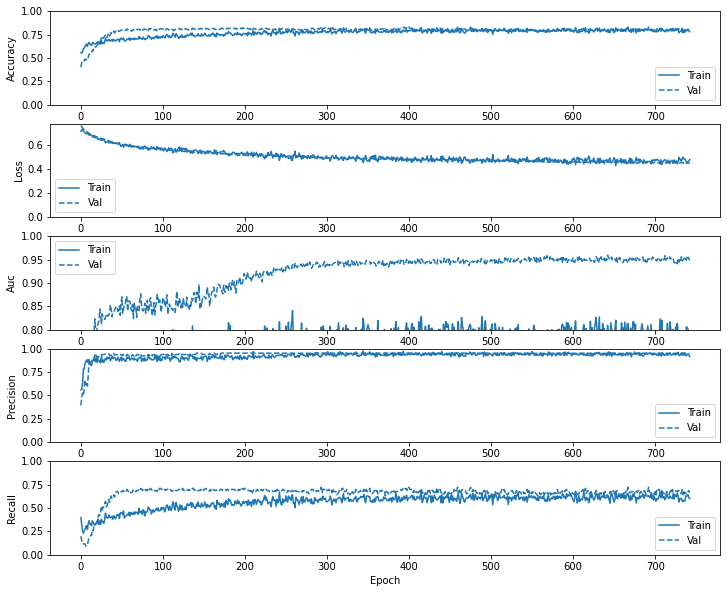

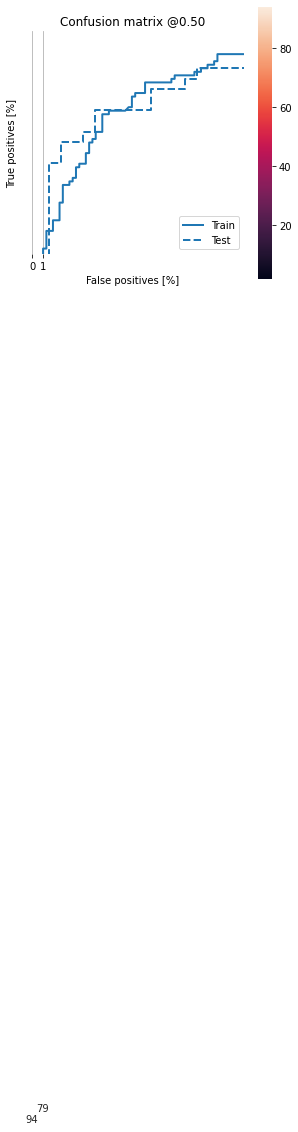

In [19]:
%%time
expId = 101
desc = str(expId) + " AngleEmbedding BasicEntanglerLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits)) 
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model_101, history_101 = runTheExperiments(expId, desc)

Epoch 1/10000
13/13 [==============================] - 689s 53s/step - loss: 0.9158 - tp: 242.7143 - fp: 192.5000 - tn: 94.0000 - fn: 39.6429 - accuracy: 0.6138 - precision: 0.5844 - recall: 0.8506 - auc: 0.6866 - val_loss: 0.8094 - val_tp: 86.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5409 - val_precision: 0.5409 - val_recall: 1.0000 - val_auc: 0.6564
Epoch 2/10000
13/13 [==============================] - 691s 53s/step - loss: 0.9090 - tp: 163.5714 - fp: 191.4286 - tn: 0.5000 - fn: 14.3571 - accuracy: 0.4344 - precision: 0.4516 - recall: 0.9160 - auc: 0.4996 - val_loss: 0.7927 - val_tp: 86.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5409 - val_precision: 0.5409 - val_recall: 1.0000 - val_auc: 0.7003
Epoch 3/10000
13/13 [==============================] - 671s 52s/step - loss: 0.9143 - tp: 156.5714 - fp: 193.4286 - tn: 0.3571 - fn: 19.5000 - accuracy: 0.4145 - precision: 0.4363 - recall: 0.8923 - auc: 0.4901 

Epoch 22/10000
13/13 [==============================] - 650s 50s/step - loss: 0.6693 - tp: 171.8571 - fp: 185.8571 - tn: 1.7143 - fn: 10.4286 - accuracy: 0.4740 - precision: 0.4866 - recall: 0.9410 - auc: 0.6193 - val_loss: 0.6225 - val_tp: 86.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5409 - val_precision: 0.5409 - val_recall: 1.0000 - val_auc: 0.8034
Epoch 23/10000
13/13 [==============================] - 651s 50s/step - loss: 0.6615 - tp: 172.9286 - fp: 187.6429 - tn: 0.7857 - fn: 8.5000 - accuracy: 0.4743 - precision: 0.4845 - recall: 0.9544 - auc: 0.6423 - val_loss: 0.6184 - val_tp: 86.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5409 - val_precision: 0.5409 - val_recall: 1.0000 - val_auc: 0.7924
Epoch 24/10000
13/13 [==============================] - 650s 50s/step - loss: 0.6682 - tp: 165.6429 - fp: 192.6429 - tn: 1.0714 - fn: 10.5000 - accuracy: 0.4528 - precision: 0.4665 - recall: 0.9348 - auc: 0.6083

Epoch 43/10000
13/13 [==============================] - 651s 50s/step - loss: 0.6021 - tp: 62.7143 - fp: 3.2143 - tn: 188.5714 - fn: 115.3571 - accuracy: 0.6847 - precision: 0.9462 - recall: 0.3633 - auc: 0.6785 - val_loss: 0.5612 - val_tp: 63.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 23.0000 - val_accuracy: 0.8050 - val_precision: 0.8873 - val_recall: 0.7326 - val_auc: 0.8213
Epoch 44/10000
13/13 [==============================] - 649s 50s/step - loss: 0.5887 - tp: 74.7857 - fp: 9.0714 - tn: 184.2143 - fn: 101.7857 - accuracy: 0.7168 - precision: 0.8835 - recall: 0.4587 - auc: 0.7342 - val_loss: 0.5596 - val_tp: 62.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 24.0000 - val_accuracy: 0.7987 - val_precision: 0.8857 - val_recall: 0.7209 - val_auc: 0.8390
Epoch 45/10000
13/13 [==============================] - 652s 50s/step - loss: 0.6080 - tp: 69.6429 - fp: 9.2143 - tn: 182.0714 - fn: 108.9286 - accuracy: 0.6763 - precision: 0.8723 - recall: 0.3902 - auc: 0.6720 - val_loss: 

13/13 [==============================] - 655s 50s/step - loss: 0.5426 - tp: 78.8571 - fp: 6.5000 - tn: 187.1429 - fn: 97.3571 - accuracy: 0.7254 - precision: 0.9265 - recall: 0.4530 - auc: 0.7937 - val_loss: 0.5242 - val_tp: 60.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 26.0000 - val_accuracy: 0.7862 - val_precision: 0.8824 - val_recall: 0.6977 - val_auc: 0.8824
Epoch 86/10000
13/13 [==============================] - 655s 50s/step - loss: 0.5451 - tp: 83.6429 - fp: 7.5714 - tn: 178.3571 - fn: 100.2857 - accuracy: 0.7081 - precision: 0.9261 - recall: 0.4569 - auc: 0.8001 - val_loss: 0.5197 - val_tp: 63.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 23.0000 - val_accuracy: 0.8050 - val_precision: 0.8873 - val_recall: 0.7326 - val_auc: 0.8780
Epoch 87/10000
13/13 [==============================] - 653s 50s/step - loss: 0.5627 - tp: 67.0714 - fp: 5.0714 - tn: 184.5714 - fn: 113.1429 - accuracy: 0.6837 - precision: 0.9270 - recall: 0.3833 - auc: 0.7708 - val_loss: 0.5161 - val_tp:

13/13 [==============================] - 657s 51s/step - loss: 0.4946 - tp: 84.8571 - fp: 16.3571 - tn: 170.3571 - fn: 98.2857 - accuracy: 0.6878 - precision: 0.8393 - recall: 0.4749 - auc: 0.8178 - val_loss: 0.4492 - val_tp: 73.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 13.0000 - val_accuracy: 0.8679 - val_precision: 0.9012 - val_recall: 0.8488 - val_auc: 0.9255
Epoch 128/10000
13/13 [==============================] - 657s 51s/step - loss: 0.5007 - tp: 83.8571 - fp: 15.5714 - tn: 174.7143 - fn: 95.7143 - accuracy: 0.6864 - precision: 0.8336 - recall: 0.4542 - auc: 0.8297 - val_loss: 0.4503 - val_tp: 74.0000 - val_fp: 11.0000 - val_tn: 62.0000 - val_fn: 12.0000 - val_accuracy: 0.8553 - val_precision: 0.8706 - val_recall: 0.8605 - val_auc: 0.9193
Epoch 129/10000
13/13 [==============================] - 656s 51s/step - loss: 0.5200 - tp: 86.2857 - fp: 12.7857 - tn: 171.7143 - fn: 99.0714 - accuracy: 0.6955 - precision: 0.8947 - recall: 0.4652 - auc: 0.7793 - val_loss: 0.4514 - val

13/13 [==============================] - 655s 50s/step - loss: 0.4801 - tp: 89.8571 - fp: 19.5714 - tn: 171.4286 - fn: 89.0000 - accuracy: 0.7078 - precision: 0.8390 - recall: 0.4995 - auc: 0.8042 - val_loss: 0.4280 - val_tp: 74.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 12.0000 - val_accuracy: 0.8868 - val_precision: 0.9250 - val_recall: 0.8605 - val_auc: 0.9367
Epoch 170/10000
13/13 [==============================] - 655s 50s/step - loss: 0.5017 - tp: 81.8571 - fp: 20.8571 - tn: 173.5000 - fn: 93.6429 - accuracy: 0.6892 - precision: 0.7858 - recall: 0.4592 - auc: 0.7910 - val_loss: 0.4252 - val_tp: 74.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 12.0000 - val_accuracy: 0.8868 - val_precision: 0.9250 - val_recall: 0.8605 - val_auc: 0.9428
Epoch 171/10000
13/13 [==============================] - 655s 50s/step - loss: 0.4926 - tp: 78.5714 - fp: 17.7857 - tn: 176.7143 - fn: 96.7857 - accuracy: 0.6940 - precision: 0.8041 - recall: 0.4686 - auc: 0.7894 - val_loss: 0.4256 - val_

13/13 [==============================] - 656s 50s/step - loss: 0.4656 - tp: 111.2857 - fp: 34.9286 - tn: 156.2143 - fn: 67.4286 - accuracy: 0.7256 - precision: 0.7637 - recall: 0.6245 - auc: 0.8306 - val_loss: 0.4112 - val_tp: 75.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 11.0000 - val_accuracy: 0.8931 - val_precision: 0.9259 - val_recall: 0.8721 - val_auc: 0.9418
Epoch 212/10000
13/13 [==============================] - 656s 50s/step - loss: 0.4828 - tp: 92.1429 - fp: 36.6429 - tn: 156.7857 - fn: 84.2857 - accuracy: 0.6744 - precision: 0.7180 - recall: 0.5308 - auc: 0.8041 - val_loss: 0.4131 - val_tp: 76.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 10.0000 - val_accuracy: 0.8994 - val_precision: 0.9268 - val_recall: 0.8837 - val_auc: 0.9426
Epoch 213/10000
13/13 [==============================] - 656s 50s/step - loss: 0.4911 - tp: 98.0714 - fp: 32.2857 - tn: 159.0000 - fn: 80.5000 - accuracy: 0.6916 - precision: 0.7398 - recall: 0.5481 - auc: 0.7968 - val_loss: 0.4130 - val

13/13 [==============================] - 656s 51s/step - loss: 0.4771 - tp: 89.1429 - fp: 21.0000 - tn: 172.7857 - fn: 86.9286 - accuracy: 0.7106 - precision: 0.8041 - recall: 0.5068 - auc: 0.8160 - val_loss: 0.4011 - val_tp: 76.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 10.0000 - val_accuracy: 0.9119 - val_precision: 0.9500 - val_recall: 0.8837 - val_auc: 0.9435
Epoch 254/10000
13/13 [==============================] - 657s 51s/step - loss: 0.4346 - tp: 96.4286 - fp: 23.7143 - tn: 166.2143 - fn: 83.5000 - accuracy: 0.7090 - precision: 0.7937 - recall: 0.5239 - auc: 0.8384 - val_loss: 0.3971 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9499
Epoch 255/10000
13/13 [==============================] - 657s 51s/step - loss: 0.4944 - tp: 91.1429 - fp: 28.7143 - tn: 160.8571 - fn: 89.1429 - accuracy: 0.6740 - precision: 0.7445 - recall: 0.4989 - auc: 0.7751 - val_loss: 0.3991 - val_

13/13 [==============================] - 655s 50s/step - loss: 0.4698 - tp: 95.5714 - fp: 31.0000 - tn: 158.1429 - fn: 85.1429 - accuracy: 0.6864 - precision: 0.7445 - recall: 0.5405 - auc: 0.8084 - val_loss: 0.3946 - val_tp: 76.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 10.0000 - val_accuracy: 0.9119 - val_precision: 0.9500 - val_recall: 0.8837 - val_auc: 0.9504
Epoch 296/10000
13/13 [==============================] - 656s 51s/step - loss: 0.4516 - tp: 110.2143 - fp: 31.0714 - tn: 160.2143 - fn: 68.3571 - accuracy: 0.7276 - precision: 0.7727 - recall: 0.6229 - auc: 0.8256 - val_loss: 0.3963 - val_tp: 76.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 10.0000 - val_accuracy: 0.9182 - val_precision: 0.9620 - val_recall: 0.8837 - val_auc: 0.9472
Epoch 297/10000
13/13 [==============================] - 657s 51s/step - loss: 0.4917 - tp: 95.7857 - fp: 26.2143 - tn: 166.3571 - fn: 81.5000 - accuracy: 0.7121 - precision: 0.8004 - recall: 0.5388 - auc: 0.8064 - val_loss: 0.3953 - val

13/13 [==============================] - 657s 51s/step - loss: 0.4788 - tp: 83.7143 - fp: 31.1429 - tn: 168.7857 - fn: 86.2143 - accuracy: 0.6677 - precision: 0.6932 - recall: 0.4781 - auc: 0.7930 - val_loss: 0.3921 - val_tp: 75.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 11.0000 - val_accuracy: 0.8931 - val_precision: 0.9259 - val_recall: 0.8721 - val_auc: 0.9452
Epoch 338/10000
13/13 [==============================] - 656s 51s/step - loss: 0.4928 - tp: 94.2143 - fp: 28.2857 - tn: 168.1429 - fn: 79.2143 - accuracy: 0.7063 - precision: 0.7562 - recall: 0.5294 - auc: 0.8126 - val_loss: 0.3879 - val_tp: 77.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 9.0000 - val_accuracy: 0.9245 - val_precision: 0.9625 - val_recall: 0.8953 - val_auc: 0.9511
Epoch 339/10000
13/13 [==============================] - 655s 51s/step - loss: 0.4470 - tp: 100.4286 - fp: 35.2857 - tn: 153.3571 - fn: 80.7857 - accuracy: 0.6779 - precision: 0.7525 - recall: 0.5382 - auc: 0.8386 - val_loss: 0.3891 - val_

13/13 [==============================] - 656s 51s/step - loss: 0.4546 - tp: 95.7857 - fp: 29.7857 - tn: 162.3571 - fn: 81.9286 - accuracy: 0.7069 - precision: 0.7820 - recall: 0.5493 - auc: 0.8239 - val_loss: 0.3900 - val_tp: 76.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 10.0000 - val_accuracy: 0.9119 - val_precision: 0.9500 - val_recall: 0.8837 - val_auc: 0.9476
Epoch 380/10000
13/13 [==============================] - 656s 51s/step - loss: 0.4482 - tp: 110.4286 - fp: 29.5714 - tn: 165.0000 - fn: 64.8571 - accuracy: 0.7511 - precision: 0.7880 - recall: 0.6445 - auc: 0.8474 - val_loss: 0.3872 - val_tp: 77.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 9.0000 - val_accuracy: 0.9119 - val_precision: 0.9390 - val_recall: 0.8953 - val_auc: 0.9518
Epoch 381/10000
13/13 [==============================] - 656s 51s/step - loss: 0.4657 - tp: 107.8571 - fp: 30.4286 - tn: 163.7143 - fn: 67.8571 - accuracy: 0.7304 - precision: 0.7787 - recall: 0.6104 - auc: 0.8288 - val_loss: 0.3905 - val

13/13 [==============================] - 656s 51s/step - loss: 0.4306 - tp: 103.0000 - fp: 29.9286 - tn: 164.9286 - fn: 72.0000 - accuracy: 0.7309 - precision: 0.7768 - recall: 0.5912 - auc: 0.8425 - val_loss: 0.3766 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9505
Epoch 422/10000
13/13 [==============================] - 657s 51s/step - loss: 0.4640 - tp: 102.4286 - fp: 31.5000 - tn: 160.5000 - fn: 75.4286 - accuracy: 0.6994 - precision: 0.7428 - recall: 0.5503 - auc: 0.8179 - val_loss: 0.3819 - val_tp: 76.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 10.0000 - val_accuracy: 0.9119 - val_precision: 0.9500 - val_recall: 0.8837 - val_auc: 0.9491
Epoch 423/10000
13/13 [==============================] - 657s 51s/step - loss: 0.5031 - tp: 101.5714 - fp: 34.6429 - tn: 149.0000 - fn: 84.6429 - accuracy: 0.6768 - precision: 0.7554 - recall: 0.5545 - auc: 0.7884 - val_loss: 0.3784 - v

13/13 [==============================] - 658s 51s/step - loss: 0.4755 - tp: 98.2857 - fp: 38.5714 - tn: 153.7143 - fn: 79.2857 - accuracy: 0.6874 - precision: 0.7322 - recall: 0.5537 - auc: 0.7970 - val_loss: 0.3817 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9495
Epoch 464/10000
13/13 [==============================] - 656s 51s/step - loss: 0.4850 - tp: 105.1429 - fp: 36.7857 - tn: 151.7857 - fn: 76.1429 - accuracy: 0.6896 - precision: 0.7448 - recall: 0.5607 - auc: 0.7879 - val_loss: 0.3812 - val_tp: 76.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 10.0000 - val_accuracy: 0.9119 - val_precision: 0.9500 - val_recall: 0.8837 - val_auc: 0.9525
Epoch 465/10000
13/13 [==============================] - 656s 51s/step - loss: 0.4427 - tp: 111.3571 - fp: 23.2857 - tn: 170.2857 - fn: 64.9286 - accuracy: 0.7640 - precision: 0.8234 - recall: 0.6306 - auc: 0.8458 - val_loss: 0.3812 - va

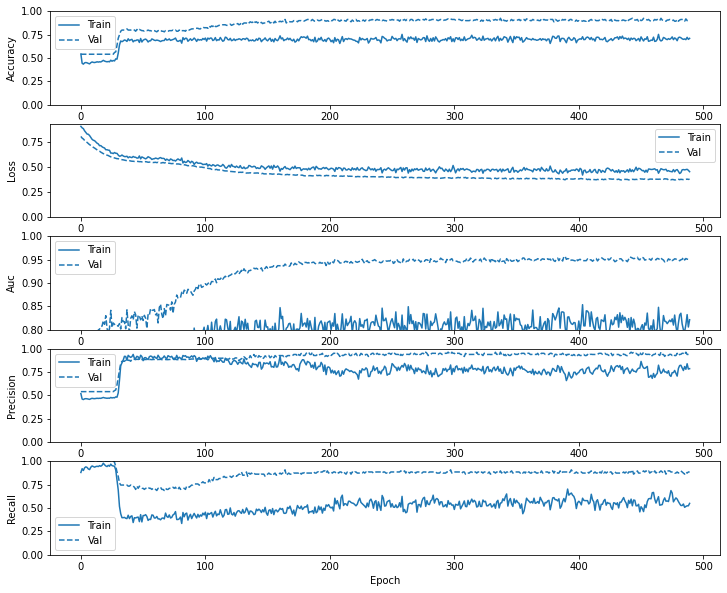

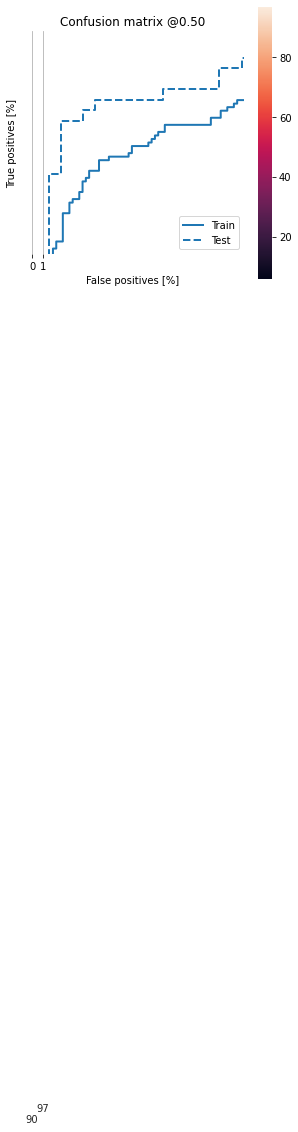

In [20]:
%%time
expId = 102
desc = str(expId) + " AngleEmbedding RandomLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.RandomLayers(weights, wires=range(n_qubits))    
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model_102, history_102 = runTheExperiments(expId, desc)

Epoch 1/10000
13/13 [==============================] - 1317s 101s/step - loss: 0.6828 - tp: 163.3571 - fp: 86.2143 - tn: 200.2857 - fn: 119.0000 - accuracy: 0.6623 - precision: 0.6701 - recall: 0.6163 - auc: 0.7529 - val_loss: 0.6737 - val_tp: 51.0000 - val_fp: 18.0000 - val_tn: 55.0000 - val_fn: 35.0000 - val_accuracy: 0.6667 - val_precision: 0.7391 - val_recall: 0.5930 - val_auc: 0.6977
Epoch 2/10000
13/13 [==============================] - 1320s 102s/step - loss: 0.6791 - tp: 44.6429 - fp: 30.4286 - tn: 161.5000 - fn: 133.2857 - accuracy: 0.5546 - precision: 0.5690 - recall: 0.2565 - auc: 0.4646 - val_loss: 0.6684 - val_tp: 49.0000 - val_fp: 10.0000 - val_tn: 63.0000 - val_fn: 37.0000 - val_accuracy: 0.7044 - val_precision: 0.8305 - val_recall: 0.5698 - val_auc: 0.7325
Epoch 3/10000
13/13 [==============================] - 1318s 101s/step - loss: 0.6641 - tp: 46.0000 - fp: 8.2143 - tn: 185.5714 - fn: 130.0714 - accuracy: 0.6415 - precision: 0.8737 - recall: 0.2682 - auc: 0.5841 - va

13/13 [==============================] - 1320s 101s/step - loss: 0.6102 - tp: 62.9286 - fp: 7.9286 - tn: 179.6429 - fn: 119.3571 - accuracy: 0.6561 - precision: 0.9066 - recall: 0.3482 - auc: 0.7426 - val_loss: 0.6056 - val_tp: 46.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 40.0000 - val_accuracy: 0.7358 - val_precision: 0.9583 - val_recall: 0.5349 - val_auc: 0.7956
Epoch 23/10000
13/13 [==============================] - 1323s 102s/step - loss: 0.6256 - tp: 53.3571 - fp: 6.0000 - tn: 182.4286 - fn: 128.0714 - accuracy: 0.6294 - precision: 0.9069 - recall: 0.2819 - auc: 0.7575 - val_loss: 0.6035 - val_tp: 46.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 40.0000 - val_accuracy: 0.7358 - val_precision: 0.9583 - val_recall: 0.5349 - val_auc: 0.7955
Epoch 24/10000
13/13 [==============================] - 1320s 102s/step - loss: 0.6060 - tp: 55.8571 - fp: 5.4286 - tn: 188.2857 - fn: 120.2857 - accuracy: 0.6617 - precision: 0.9226 - recall: 0.3245 - auc: 0.7413 - val_loss: 0.6005 - 

13/13 [==============================] - 1325s 102s/step - loss: 0.5973 - tp: 73.0714 - fp: 6.7857 - tn: 184.8571 - fn: 105.1429 - accuracy: 0.6834 - precision: 0.9306 - recall: 0.3805 - auc: 0.6680 - val_loss: 0.5599 - val_tp: 50.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 36.0000 - val_accuracy: 0.7547 - val_precision: 0.9434 - val_recall: 0.5814 - val_auc: 0.8805
Epoch 65/10000
13/13 [==============================] - 1322s 102s/step - loss: 0.5857 - tp: 70.5000 - fp: 9.5714 - tn: 182.0000 - fn: 107.7857 - accuracy: 0.6806 - precision: 0.8823 - recall: 0.3866 - auc: 0.6948 - val_loss: 0.5587 - val_tp: 52.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 34.0000 - val_accuracy: 0.7673 - val_precision: 0.9455 - val_recall: 0.6047 - val_auc: 0.8922
Epoch 66/10000
13/13 [==============================] - 1320s 102s/step - loss: 0.5482 - tp: 84.7143 - fp: 8.5714 - tn: 184.0714 - fn: 92.5000 - accuracy: 0.7414 - precision: 0.9130 - recall: 0.5044 - auc: 0.7561 - val_loss: 0.5572 - v

13/13 [==============================] - 1325s 102s/step - loss: 0.5487 - tp: 89.8571 - fp: 6.4286 - tn: 181.4286 - fn: 92.1429 - accuracy: 0.7286 - precision: 0.9362 - recall: 0.4924 - auc: 0.7446 - val_loss: 0.5404 - val_tp: 55.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 31.0000 - val_accuracy: 0.7799 - val_precision: 0.9322 - val_recall: 0.6395 - val_auc: 0.9133
Epoch 107/10000
13/13 [==============================] - 1325s 102s/step - loss: 0.5662 - tp: 84.6429 - fp: 6.5000 - tn: 182.5000 - fn: 96.2143 - accuracy: 0.7220 - precision: 0.9333 - recall: 0.4587 - auc: 0.7360 - val_loss: 0.5399 - val_tp: 56.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 30.0000 - val_accuracy: 0.7862 - val_precision: 0.9333 - val_recall: 0.6512 - val_auc: 0.8941
Epoch 108/10000
13/13 [==============================] - 1322s 102s/step - loss: 0.5606 - tp: 82.5714 - fp: 9.4286 - tn: 180.1429 - fn: 97.7143 - accuracy: 0.7062 - precision: 0.8699 - recall: 0.4657 - auc: 0.7247 - val_loss: 0.5383 - v

13/13 [==============================] - 1322s 102s/step - loss: 0.5584 - tp: 86.0714 - fp: 9.9286 - tn: 176.7857 - fn: 97.0714 - accuracy: 0.7136 - precision: 0.9028 - recall: 0.4864 - auc: 0.7187 - val_loss: 0.5350 - val_tp: 56.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 30.0000 - val_accuracy: 0.7862 - val_precision: 0.9333 - val_recall: 0.6512 - val_auc: 0.9106
Epoch 128/10000
13/13 [==============================] - 1319s 102s/step - loss: 0.5611 - tp: 84.5714 - fp: 8.3571 - tn: 181.9286 - fn: 95.0000 - accuracy: 0.7149 - precision: 0.9111 - recall: 0.4667 - auc: 0.7271 - val_loss: 0.5334 - val_tp: 56.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 30.0000 - val_accuracy: 0.7862 - val_precision: 0.9333 - val_recall: 0.6512 - val_auc: 0.9108
Epoch 129/10000
13/13 [==============================] - 1322s 102s/step - loss: 0.5739 - tp: 82.7143 - fp: 8.0714 - tn: 176.4286 - fn: 102.6429 - accuracy: 0.6989 - precision: 0.9314 - recall: 0.4485 - auc: 0.7355 - val_loss: 0.5330 - 

13/13 [==============================] - 1320s 102s/step - loss: 0.5486 - tp: 84.6429 - fp: 8.5714 - tn: 183.0714 - fn: 93.5714 - accuracy: 0.7228 - precision: 0.9056 - recall: 0.4751 - auc: 0.7031 - val_loss: 0.5293 - val_tp: 57.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 29.0000 - val_accuracy: 0.7925 - val_precision: 0.9344 - val_recall: 0.6628 - val_auc: 0.9080
Epoch 149/10000
13/13 [==============================] - 1323s 102s/step - loss: 0.5841 - tp: 83.3571 - fp: 10.1429 - tn: 176.5000 - fn: 99.8571 - accuracy: 0.6797 - precision: 0.8743 - recall: 0.4249 - auc: 0.6951 - val_loss: 0.5286 - val_tp: 57.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 29.0000 - val_accuracy: 0.7925 - val_precision: 0.9344 - val_recall: 0.6628 - val_auc: 0.9112
Epoch 150/10000
13/13 [==============================] - 1321s 102s/step - loss: 0.5431 - tp: 80.4286 - fp: 5.7143 - tn: 190.8571 - fn: 92.8571 - accuracy: 0.7345 - precision: 0.9296 - recall: 0.4628 - auc: 0.7421 - val_loss: 0.5269 - 

13/13 [==============================] - 1322s 102s/step - loss: 0.5499 - tp: 87.7857 - fp: 6.5714 - tn: 184.4286 - fn: 91.0714 - accuracy: 0.7293 - precision: 0.9453 - recall: 0.4772 - auc: 0.7332 - val_loss: 0.5201 - val_tp: 58.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 28.0000 - val_accuracy: 0.7987 - val_precision: 0.9355 - val_recall: 0.6744 - val_auc: 0.9150
Epoch 170/10000
13/13 [==============================] - 1323s 102s/step - loss: 0.5441 - tp: 87.7857 - fp: 8.2857 - tn: 186.0714 - fn: 87.7143 - accuracy: 0.7390 - precision: 0.8973 - recall: 0.4984 - auc: 0.7276 - val_loss: 0.5166 - val_tp: 56.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 30.0000 - val_accuracy: 0.7862 - val_precision: 0.9333 - val_recall: 0.6512 - val_auc: 0.9113
Epoch 171/10000
13/13 [==============================] - 1322s 102s/step - loss: 0.5308 - tp: 84.5000 - fp: 6.6429 - tn: 187.8571 - fn: 90.8571 - accuracy: 0.7425 - precision: 0.9290 - recall: 0.4928 - auc: 0.7510 - val_loss: 0.5183 - v

13/13 [==============================] - 1321s 102s/step - loss: 0.5290 - tp: 92.0000 - fp: 2.7857 - tn: 188.3571 - fn: 86.7143 - accuracy: 0.7543 - precision: 0.9737 - recall: 0.5049 - auc: 0.7188 - val_loss: 0.5100 - val_tp: 61.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 25.0000 - val_accuracy: 0.8176 - val_precision: 0.9385 - val_recall: 0.7093 - val_auc: 0.9107
Epoch 212/10000
13/13 [==============================] - 1320s 101s/step - loss: 0.5600 - tp: 81.5714 - fp: 11.0000 - tn: 182.4286 - fn: 94.8571 - accuracy: 0.7110 - precision: 0.8798 - recall: 0.4615 - auc: 0.7062 - val_loss: 0.5081 - val_tp: 61.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 25.0000 - val_accuracy: 0.8239 - val_precision: 0.9531 - val_recall: 0.7093 - val_auc: 0.9191
Epoch 213/10000
13/13 [==============================] - 1322s 102s/step - loss: 0.5437 - tp: 88.7143 - fp: 9.4286 - tn: 181.8571 - fn: 89.8571 - accuracy: 0.7229 - precision: 0.8838 - recall: 0.4813 - auc: 0.7574 - val_loss: 0.5086 - 

13/13 [==============================] - 1320s 102s/step - loss: 0.5110 - tp: 94.7143 - fp: 5.7143 - tn: 188.0714 - fn: 81.3571 - accuracy: 0.7687 - precision: 0.9351 - recall: 0.5464 - auc: 0.7785 - val_loss: 0.5169 - val_tp: 60.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 26.0000 - val_accuracy: 0.8113 - val_precision: 0.9375 - val_recall: 0.6977 - val_auc: 0.9236
Epoch 254/10000
13/13 [==============================] - 1320s 101s/step - loss: 0.5018 - tp: 98.1429 - fp: 7.5714 - tn: 182.3571 - fn: 81.7857 - accuracy: 0.7614 - precision: 0.9229 - recall: 0.5466 - auc: 0.7707 - val_loss: 0.5137 - val_tp: 61.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 25.0000 - val_accuracy: 0.8239 - val_precision: 0.9531 - val_recall: 0.7093 - val_auc: 0.9124
Epoch 255/10000
13/13 [==============================] - 1320s 102s/step - loss: 0.5122 - tp: 92.0714 - fp: 4.1429 - tn: 185.4286 - fn: 88.2143 - accuracy: 0.7541 - precision: 0.9677 - recall: 0.5092 - auc: 0.8078 - val_loss: 0.5145 - v

13/13 [==============================] - 1316s 101s/step - loss: 0.5062 - tp: 90.7143 - fp: 7.2857 - tn: 191.4286 - fn: 80.4286 - accuracy: 0.7881 - precision: 0.9158 - recall: 0.5799 - auc: 0.7850 - val_loss: 0.5262 - val_tp: 60.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 26.0000 - val_accuracy: 0.8113 - val_precision: 0.9375 - val_recall: 0.6977 - val_auc: 0.9249
Epoch 275/10000
13/13 [==============================] - 1318s 101s/step - loss: 0.5077 - tp: 96.4286 - fp: 5.5000 - tn: 185.5714 - fn: 82.3571 - accuracy: 0.7668 - precision: 0.9524 - recall: 0.5462 - auc: 0.7865 - val_loss: 0.5263 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9216
Epoch 276/10000
13/13 [==============================] - 1319s 101s/step - loss: 0.5485 - tp: 88.4286 - fp: 3.9286 - tn: 185.2857 - fn: 92.2143 - accuracy: 0.7292 - precision: 0.9592 - recall: 0.4690 - auc: 0.7622 - val_loss: 0.5276 - v

13/13 [==============================] - 1320s 102s/step - loss: 0.5032 - tp: 103.5000 - fp: 10.7143 - tn: 178.4286 - fn: 77.2143 - accuracy: 0.7648 - precision: 0.9043 - recall: 0.5766 - auc: 0.7975 - val_loss: 0.5314 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9217
Epoch 296/10000
13/13 [==============================] - 1316s 101s/step - loss: 0.5269 - tp: 104.5000 - fp: 8.9286 - tn: 182.3571 - fn: 74.0714 - accuracy: 0.7667 - precision: 0.9075 - recall: 0.5795 - auc: 0.7658 - val_loss: 0.5319 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9261
Epoch 297/10000
13/13 [==============================] - 1315s 101s/step - loss: 0.4988 - tp: 100.9286 - fp: 5.8571 - tn: 186.7143 - fn: 76.3571 - accuracy: 0.7759 - precision: 0.9448 - recall: 0.5690 - auc: 0.7906 - val_loss: 0.5292

13/13 [==============================] - 1320s 102s/step - loss: 0.5093 - tp: 101.7143 - fp: 6.8571 - tn: 183.5714 - fn: 77.7143 - accuracy: 0.7616 - precision: 0.9301 - recall: 0.5618 - auc: 0.7953 - val_loss: 0.5352 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9259
Epoch 317/10000
13/13 [==============================] - 1319s 101s/step - loss: 0.4801 - tp: 103.0714 - fp: 2.2857 - tn: 191.5000 - fn: 73.0000 - accuracy: 0.8006 - precision: 0.9853 - recall: 0.5832 - auc: 0.8334 - val_loss: 0.5335 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9250
Epoch 318/10000
13/13 [==============================] - 1318s 101s/step - loss: 0.4950 - tp: 99.5714 - fp: 5.6429 - tn: 189.0714 - fn: 75.5714 - accuracy: 0.7840 - precision: 0.9540 - recall: 0.5747 - auc: 0.8075 - val_loss: 0.5309 -

13/13 [==============================] - 1319s 102s/step - loss: 0.5173 - tp: 93.5714 - fp: 9.7143 - tn: 190.2143 - fn: 76.3571 - accuracy: 0.7624 - precision: 0.8930 - recall: 0.5388 - auc: 0.7388 - val_loss: 0.5282 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9357
Epoch 338/10000
13/13 [==============================] - 1317s 101s/step - loss: 0.5228 - tp: 91.2857 - fp: 7.2857 - tn: 189.1429 - fn: 82.1429 - accuracy: 0.7649 - precision: 0.9331 - recall: 0.5266 - auc: 0.7513 - val_loss: 0.5283 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9243
Epoch 339/10000
13/13 [==============================] - 1319s 101s/step - loss: 0.5046 - tp: 107.1429 - fp: 7.8571 - tn: 180.7857 - fn: 74.0714 - accuracy: 0.7689 - precision: 0.9372 - recall: 0.5808 - auc: 0.7771 - val_loss: 0.5286 - 

Epoch 358/10000
13/13 [==============================] - 1316s 101s/step - loss: 0.5035 - tp: 99.2857 - fp: 5.4286 - tn: 185.6429 - fn: 79.5000 - accuracy: 0.7780 - precision: 0.9614 - recall: 0.5632 - auc: 0.7700 - val_loss: 0.5233 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9330
Epoch 359/10000
13/13 [==============================] - 1315s 101s/step - loss: 0.4890 - tp: 109.5000 - fp: 6.1429 - tn: 181.3571 - fn: 72.8571 - accuracy: 0.7888 - precision: 0.9532 - recall: 0.6031 - auc: 0.7985 - val_loss: 0.5195 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9392
Epoch 360/10000
13/13 [==============================] - 1319s 101s/step - loss: 0.5324 - tp: 100.8571 - fp: 8.4286 - tn: 180.5714 - fn: 80.0000 - accuracy: 0.7571 - precision: 0.9182 - recall: 0.5533 - auc: 0.7533 - va

Epoch 379/10000
13/13 [==============================] - 1316s 101s/step - loss: 0.4920 - tp: 104.0714 - fp: 4.3571 - tn: 187.7857 - fn: 73.6429 - accuracy: 0.7877 - precision: 0.9616 - recall: 0.5867 - auc: 0.7701 - val_loss: 0.5199 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9450
Epoch 380/10000
13/13 [==============================] - 1316s 101s/step - loss: 0.5137 - tp: 96.2857 - fp: 8.3571 - tn: 186.2143 - fn: 79.0000 - accuracy: 0.7615 - precision: 0.9077 - recall: 0.5492 - auc: 0.7470 - val_loss: 0.5204 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9454
Epoch 381/10000
13/13 [==============================] - 1317s 101s/step - loss: 0.4706 - tp: 109.0000 - fp: 6.0714 - tn: 188.0714 - fn: 66.7143 - accuracy: 0.8033 - precision: 0.9457 - recall: 0.6250 - auc: 0.7880 - va

Epoch 400/10000
13/13 [==============================] - 1318s 101s/step - loss: 0.5053 - tp: 101.5000 - fp: 7.2857 - tn: 182.9286 - fn: 78.1429 - accuracy: 0.7578 - precision: 0.9315 - recall: 0.5556 - auc: 0.7804 - val_loss: 0.5101 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9398
Epoch 401/10000
13/13 [==============================] - 1316s 101s/step - loss: 0.4756 - tp: 103.7143 - fp: 6.8571 - tn: 186.7143 - fn: 72.5714 - accuracy: 0.7901 - precision: 0.9411 - recall: 0.5974 - auc: 0.8016 - val_loss: 0.5099 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9404
Epoch 402/10000
13/13 [==============================] - 1315s 101s/step - loss: 0.5099 - tp: 104.9286 - fp: 6.3571 - tn: 185.2143 - fn: 73.3571 - accuracy: 0.7748 - precision: 0.9460 - recall: 0.5707 - auc: 0.7774 - v

Epoch 421/10000
13/13 [==============================] - 1316s 101s/step - loss: 0.4753 - tp: 105.7857 - fp: 3.7143 - tn: 191.1429 - fn: 69.2143 - accuracy: 0.8091 - precision: 0.9659 - recall: 0.6117 - auc: 0.7902 - val_loss: 0.5134 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9397
Epoch 422/10000
13/13 [==============================] - 1316s 101s/step - loss: 0.4941 - tp: 108.9286 - fp: 8.5714 - tn: 183.4286 - fn: 68.9286 - accuracy: 0.7841 - precision: 0.9060 - recall: 0.6050 - auc: 0.7988 - val_loss: 0.5136 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9384
Epoch 423/10000
13/13 [==============================] - 1318s 101s/step - loss: 0.5412 - tp: 99.8571 - fp: 7.2857 - tn: 176.3571 - fn: 86.3571 - accuracy: 0.7326 - precision: 0.9256 - recall: 0.5286 - auc: 0.7360 - va

Epoch 442/10000
13/13 [==============================] - 1316s 101s/step - loss: 0.5156 - tp: 98.5714 - fp: 7.4286 - tn: 181.6429 - fn: 82.2143 - accuracy: 0.7551 - precision: 0.9291 - recall: 0.5372 - auc: 0.7485 - val_loss: 0.5074 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9498
Epoch 443/10000
13/13 [==============================] - 1314s 101s/step - loss: 0.4881 - tp: 108.5000 - fp: 9.8571 - tn: 181.7857 - fn: 69.7143 - accuracy: 0.7804 - precision: 0.9079 - recall: 0.6130 - auc: 0.8064 - val_loss: 0.5086 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9386
Epoch 444/10000
13/13 [==============================] - 1317s 101s/step - loss: 0.4807 - tp: 102.1429 - fp: 7.0714 - tn: 188.5000 - fn: 72.1429 - accuracy: 0.7968 - precision: 0.9396 - recall: 0.6045 - auc: 0.7878 - va

Epoch 463/10000
13/13 [==============================] - 1319s 101s/step - loss: 0.4883 - tp: 97.3571 - fp: 4.2143 - tn: 188.0714 - fn: 80.2143 - accuracy: 0.7781 - precision: 0.9646 - recall: 0.5589 - auc: 0.8108 - val_loss: 0.5026 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9470
Epoch 464/10000
13/13 [==============================] - 1315s 101s/step - loss: 0.4886 - tp: 105.0000 - fp: 7.3571 - tn: 181.2143 - fn: 76.2857 - accuracy: 0.7784 - precision: 0.9409 - recall: 0.5852 - auc: 0.7831 - val_loss: 0.5012 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9497
Epoch 465/10000
13/13 [==============================] - 1319s 101s/step - loss: 0.4488 - tp: 115.1429 - fp: 7.0000 - tn: 186.5714 - fn: 61.1429 - accuracy: 0.8226 - precision: 0.9442 - recall: 0.6608 - auc: 0.8219 - va

Epoch 484/10000
13/13 [==============================] - 1316s 101s/step - loss: 0.5059 - tp: 108.0000 - fp: 7.2143 - tn: 172.3571 - fn: 82.2857 - accuracy: 0.7558 - precision: 0.9407 - recall: 0.5708 - auc: 0.7853 - val_loss: 0.5034 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9422
Epoch 485/10000
13/13 [==============================] - 1318s 101s/step - loss: 0.4857 - tp: 109.4286 - fp: 6.0714 - tn: 184.3571 - fn: 70.0000 - accuracy: 0.7856 - precision: 0.9412 - recall: 0.5891 - auc: 0.7840 - val_loss: 0.5041 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9381
Epoch 486/10000
13/13 [==============================] - 1313s 101s/step - loss: 0.4771 - tp: 106.3571 - fp: 7.9286 - tn: 187.7143 - fn: 67.8571 - accuracy: 0.7877 - precision: 0.9205 - recall: 0.6064 - auc: 0.7659 - v

Epoch 505/10000
13/13 [==============================] - 1313s 101s/step - loss: 0.5018 - tp: 108.9286 - fp: 6.0000 - tn: 177.6429 - fn: 77.2857 - accuracy: 0.7582 - precision: 0.9441 - recall: 0.5712 - auc: 0.7714 - val_loss: 0.5010 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9406
Epoch 506/10000
13/13 [==============================] - 1320s 102s/step - loss: 0.4780 - tp: 111.4286 - fp: 5.4286 - tn: 184.8571 - fn: 68.1429 - accuracy: 0.8000 - precision: 0.9479 - recall: 0.6111 - auc: 0.7836 - val_loss: 0.5004 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9414
Epoch 507/10000
13/13 [==============================] - 1317s 101s/step - loss: 0.4834 - tp: 107.0000 - fp: 7.3571 - tn: 186.1429 - fn: 69.3571 - accuracy: 0.7930 - precision: 0.9334 - recall: 0.6003 - auc: 0.7855 - v

Epoch 526/10000
13/13 [==============================] - 1317s 101s/step - loss: 0.4951 - tp: 101.5714 - fp: 8.4286 - tn: 183.7857 - fn: 76.0714 - accuracy: 0.7670 - precision: 0.9138 - recall: 0.5745 - auc: 0.7652 - val_loss: 0.5026 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9415
Epoch 527/10000
13/13 [==============================] - 1318s 101s/step - loss: 0.4876 - tp: 107.4286 - fp: 7.4286 - tn: 184.4286 - fn: 70.5714 - accuracy: 0.7866 - precision: 0.9386 - recall: 0.5930 - auc: 0.7796 - val_loss: 0.4973 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9395
Epoch 528/10000
13/13 [==============================] - 1316s 101s/step - loss: 0.4642 - tp: 110.3571 - fp: 4.7857 - tn: 186.7857 - fn: 67.9286 - accuracy: 0.8042 - precision: 0.9566 - recall: 0.6274 - auc: 0.8198 - v

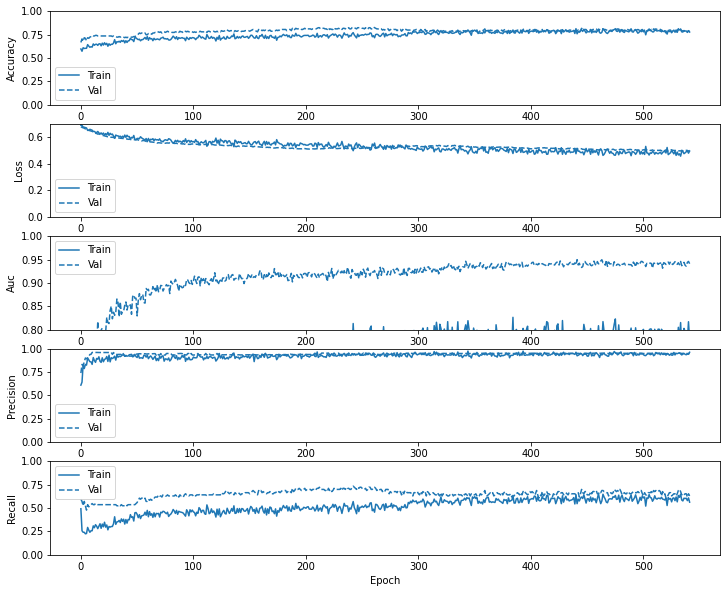

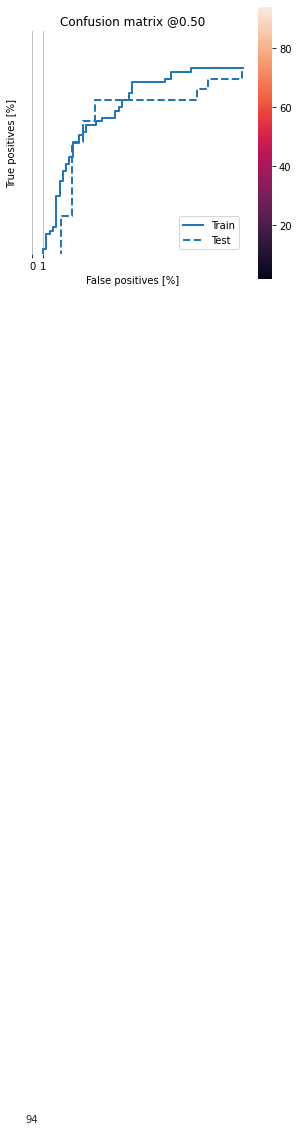

In [21]:
%%time
expId = 103
desc = str(expId) + " AngleEmbedding StronglyEntanglingLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))   
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, {"weights": (n_layers, n_qubits, 3)}, output_dim=n_qubits)

model_103, history_103 = runTheExperiments(expId, desc)

## IQPEmbedding

Epoch 1/10000
13/13 [==============================] - 775s 60s/step - loss: 0.6998 - tp: 121.7857 - fp: 41.6429 - tn: 244.8571 - fn: 160.5714 - accuracy: 0.6617 - precision: 0.7631 - recall: 0.4571 - auc: 0.7364 - val_loss: 0.7144 - val_tp: 21.0000 - val_fp: 19.0000 - val_tn: 54.0000 - val_fn: 65.0000 - val_accuracy: 0.4717 - val_precision: 0.5250 - val_recall: 0.2442 - val_auc: 0.4141
Epoch 2/10000
13/13 [==============================] - 777s 60s/step - loss: 0.7037 - tp: 54.5000 - fp: 49.9286 - tn: 142.0000 - fn: 123.4286 - accuracy: 0.5419 - precision: 0.5225 - recall: 0.3342 - auc: 0.5109 - val_loss: 0.7191 - val_tp: 22.0000 - val_fp: 17.0000 - val_tn: 56.0000 - val_fn: 64.0000 - val_accuracy: 0.4906 - val_precision: 0.5641 - val_recall: 0.2558 - val_auc: 0.3820
Epoch 3/10000
13/13 [==============================] - 777s 60s/step - loss: 0.7134 - tp: 47.9286 - fp: 42.7857 - tn: 151.0000 - fn: 128.1429 - accuracy: 0.5535 - precision: 0.5391 - recall: 0.2793 - auc: 0.4403 - val_los

13/13 [==============================] - 777s 60s/step - loss: 0.6764 - tp: 49.3571 - fp: 11.9286 - tn: 179.8571 - fn: 128.7143 - accuracy: 0.6194 - precision: 0.8021 - recall: 0.2733 - auc: 0.5590 - val_loss: 0.7886 - val_tp: 1.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 85.0000 - val_accuracy: 0.4465 - val_precision: 0.2500 - val_recall: 0.0116 - val_auc: 0.1843
Epoch 44/10000
13/13 [==============================] - 778s 60s/step - loss: 0.6811 - tp: 37.7143 - fp: 5.6429 - tn: 187.6429 - fn: 138.8571 - accuracy: 0.6123 - precision: 0.8450 - recall: 0.2031 - auc: 0.5318 - val_loss: 0.7863 - val_tp: 0.0000e+00 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 86.0000 - val_accuracy: 0.4403 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.2279
Epoch 45/10000
13/13 [==============================] - 781s 60s/step - loss: 0.6854 - tp: 42.8571 - fp: 7.0000 - tn: 184.2857 - fn: 135.7143 - accuracy: 0.6056 - precision: 0.8460 - recall: 0.2276 - auc: 0.5083 - val_loss: 0.79

Epoch 64/10000
13/13 [==============================] - 778s 60s/step - loss: 0.6718 - tp: 47.3571 - fp: 6.4286 - tn: 185.2143 - fn: 130.8571 - accuracy: 0.6153 - precision: 0.8845 - recall: 0.2423 - auc: 0.5603 - val_loss: 0.7958 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 73.0000 - val_fn: 86.0000 - val_accuracy: 0.4591 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.1680
Epoch 65/10000
13/13 [==============================] - 779s 60s/step - loss: 0.6697 - tp: 46.0000 - fp: 3.8571 - tn: 187.7143 - fn: 132.2857 - accuracy: 0.6298 - precision: 0.9140 - recall: 0.2531 - auc: 0.5884 - val_loss: 0.7988 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 73.0000 - val_fn: 86.0000 - val_accuracy: 0.4591 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.1788
Epoch 66/10000
13/13 [==============================] - 776s 60s/step - loss: 0.6726 - tp: 41.7857 - fp: 5.7143 - tn: 186.9286 - fn: 135.4286 - accuracy: 0.6254 - precision: 0.8774 - recall: 0.2

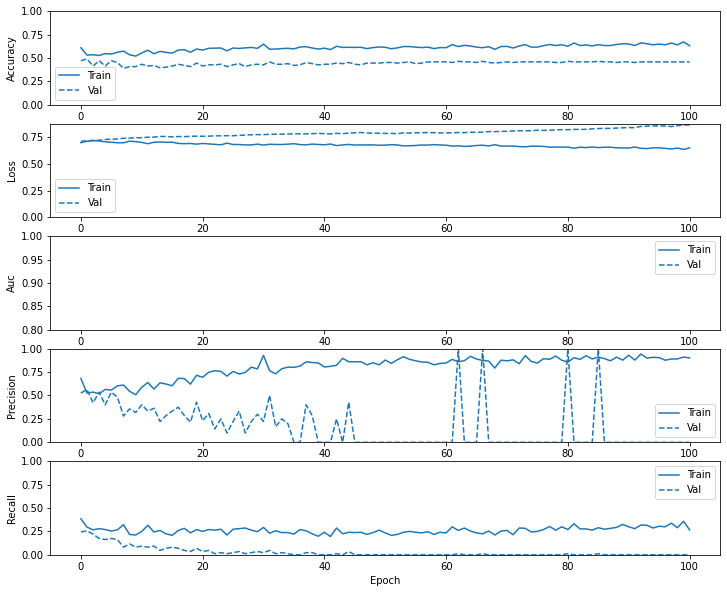

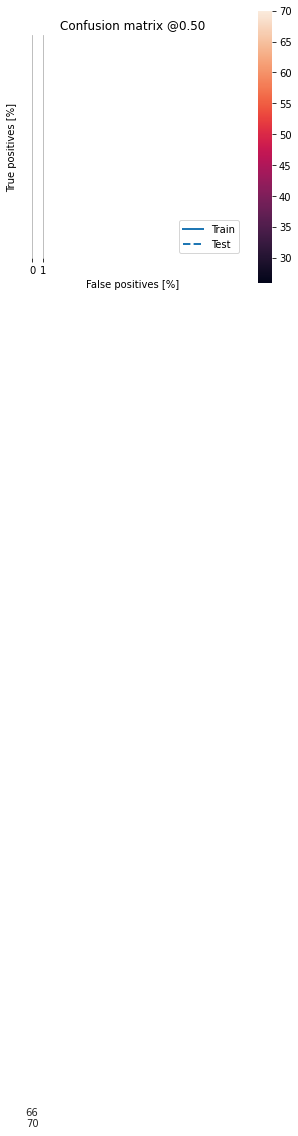

In [22]:
%%time
expId = 104
desc = str(expId) + " IQPEmbedding BasicEntanglerLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.IQPEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))    
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model_104, history_104 = runTheExperiments(expId, desc)

Epoch 1/10000
13/13 [==============================] - 453s 35s/step - loss: 0.6944 - tp: 153.2857 - fp: 167.7143 - tn: 22.7857 - fn: 26.0714 - accuracy: 0.4756 - precision: 0.4749 - recall: 0.8636 - auc: 0.4941 - val_loss: 0.6723 - val_tp: 74.0000 - val_fp: 67.0000 - val_tn: 6.0000 - val_fn: 12.0000 - val_accuracy: 0.5031 - val_precision: 0.5248 - val_recall: 0.8605 - val_auc: 0.6444
Epoch 2/10000
13/13 [==============================] - 486s 38s/step - loss: 0.6968 - tp: 140.6429 - fp: 164.4286 - tn: 27.5000 - fn: 37.2857 - accuracy: 0.4489 - precision: 0.4525 - recall: 0.7876 - auc: 0.5070 - val_loss: 0.6730 - val_tp: 75.0000 - val_fp: 65.0000 - val_tn: 8.0000 - val_fn: 11.0000 - val_accuracy: 0.5220 - val_precision: 0.5357 - val_recall: 0.8721 - val_auc: 0.6367
Epoch 3/10000
13/13 [==============================] - 523s 40s/step - loss: 0.6970 - tp: 135.1429 - fp: 166.4286 - tn: 27.3571 - fn: 40.9286 - accuracy: 0.4316 - precision: 0.4366 - recall: 0.7711 - auc: 0.4817 - val_loss: 

13/13 [==============================] - 523s 40s/step - loss: 0.6885 - tp: 66.0714 - fp: 48.7143 - tn: 138.8571 - fn: 116.2143 - accuracy: 0.5584 - precision: 0.5956 - recall: 0.3686 - auc: 0.5360 - val_loss: 0.6601 - val_tp: 55.0000 - val_fp: 16.0000 - val_tn: 57.0000 - val_fn: 31.0000 - val_accuracy: 0.7044 - val_precision: 0.7746 - val_recall: 0.6395 - val_auc: 0.7320
Epoch 23/10000
13/13 [==============================] - 524s 40s/step - loss: 0.6803 - tp: 64.0714 - fp: 44.9286 - tn: 143.5000 - fn: 117.3571 - accuracy: 0.5670 - precision: 0.6071 - recall: 0.3610 - auc: 0.5674 - val_loss: 0.6562 - val_tp: 59.0000 - val_fp: 22.0000 - val_tn: 51.0000 - val_fn: 27.0000 - val_accuracy: 0.6918 - val_precision: 0.7284 - val_recall: 0.6860 - val_auc: 0.7814
Epoch 24/10000
13/13 [==============================] - 525s 40s/step - loss: 0.6829 - tp: 57.7857 - fp: 43.9286 - tn: 149.7857 - fn: 118.3571 - accuracy: 0.5652 - precision: 0.5849 - recall: 0.3403 - auc: 0.5430 - val_loss: 0.6562 - v

13/13 [==============================] - 523s 40s/step - loss: 0.6767 - tp: 41.9286 - fp: 12.7857 - tn: 179.0000 - fn: 136.1429 - accuracy: 0.6065 - precision: 0.7715 - recall: 0.2531 - auc: 0.6020 - val_loss: 0.6470 - val_tp: 52.0000 - val_fp: 9.0000 - val_tn: 64.0000 - val_fn: 34.0000 - val_accuracy: 0.7296 - val_precision: 0.8525 - val_recall: 0.6047 - val_auc: 0.8041
Epoch 44/10000
13/13 [==============================] - 523s 40s/step - loss: 0.6755 - tp: 46.9286 - fp: 13.3571 - tn: 179.9286 - fn: 129.6429 - accuracy: 0.6232 - precision: 0.7695 - recall: 0.2781 - auc: 0.5987 - val_loss: 0.6481 - val_tp: 52.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 34.0000 - val_accuracy: 0.7421 - val_precision: 0.8814 - val_recall: 0.6047 - val_auc: 0.7983
Epoch 45/10000
13/13 [==============================] - 525s 40s/step - loss: 0.6891 - tp: 42.1429 - fp: 10.7143 - tn: 180.5714 - fn: 136.4286 - accuracy: 0.5970 - precision: 0.7814 - recall: 0.2368 - auc: 0.5060 - val_loss: 0.6494 - val

13/13 [==============================] - 523s 40s/step - loss: 0.6640 - tp: 49.2857 - fp: 9.7143 - tn: 181.9286 - fn: 128.9286 - accuracy: 0.6312 - precision: 0.8369 - recall: 0.2986 - auc: 0.6153 - val_loss: 0.6418 - val_tp: 52.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 34.0000 - val_accuracy: 0.7610 - val_precision: 0.9286 - val_recall: 0.6047 - val_auc: 0.8101
Epoch 65/10000
13/13 [==============================] - 524s 40s/step - loss: 0.6808 - tp: 45.7143 - fp: 11.2143 - tn: 180.3571 - fn: 132.5714 - accuracy: 0.6035 - precision: 0.7839 - recall: 0.2408 - auc: 0.5652 - val_loss: 0.6416 - val_tp: 53.0000 - val_fp: 11.0000 - val_tn: 62.0000 - val_fn: 33.0000 - val_accuracy: 0.7233 - val_precision: 0.8281 - val_recall: 0.6163 - val_auc: 0.8147
Epoch 66/10000
13/13 [==============================] - 525s 40s/step - loss: 0.6768 - tp: 43.8571 - fp: 6.0000 - tn: 186.6429 - fn: 133.3571 - accuracy: 0.6237 - precision: 0.8664 - recall: 0.2458 - auc: 0.5745 - val_loss: 0.6395 - val_

13/13 [==============================] - 526s 41s/step - loss: 0.6693 - tp: 44.6429 - fp: 6.5714 - tn: 187.0714 - fn: 131.5714 - accuracy: 0.6346 - precision: 0.8718 - recall: 0.2633 - auc: 0.5858 - val_loss: 0.6323 - val_tp: 53.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 33.0000 - val_accuracy: 0.7547 - val_precision: 0.8983 - val_recall: 0.6163 - val_auc: 0.8105
Epoch 86/10000
13/13 [==============================] - 526s 40s/step - loss: 0.6830 - tp: 42.0000 - fp: 5.5714 - tn: 180.3571 - fn: 141.9286 - accuracy: 0.5895 - precision: 0.8515 - recall: 0.2209 - auc: 0.5666 - val_loss: 0.6343 - val_tp: 54.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 32.0000 - val_accuracy: 0.7673 - val_precision: 0.9153 - val_recall: 0.6279 - val_auc: 0.7871
Epoch 87/10000
13/13 [==============================] - 525s 40s/step - loss: 0.6838 - tp: 37.9286 - fp: 6.0714 - tn: 183.5714 - fn: 142.2857 - accuracy: 0.5914 - precision: 0.8567 - recall: 0.1947 - auc: 0.5498 - val_loss: 0.6324 - val_tp

13/13 [==============================] - 525s 40s/step - loss: 0.6742 - tp: 45.9286 - fp: 9.2857 - tn: 178.5714 - fn: 136.0714 - accuracy: 0.6035 - precision: 0.8517 - recall: 0.2548 - auc: 0.5833 - val_loss: 0.6281 - val_tp: 55.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 31.0000 - val_accuracy: 0.7610 - val_precision: 0.8871 - val_recall: 0.6395 - val_auc: 0.7768
Epoch 107/10000
13/13 [==============================] - 524s 40s/step - loss: 0.6704 - tp: 42.9286 - fp: 9.5000 - tn: 179.5000 - fn: 137.9286 - accuracy: 0.6051 - precision: 0.8093 - recall: 0.2456 - auc: 0.5623 - val_loss: 0.6240 - val_tp: 54.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 32.0000 - val_accuracy: 0.7547 - val_precision: 0.8852 - val_recall: 0.6279 - val_auc: 0.8122
Epoch 108/10000
13/13 [==============================] - 525s 40s/step - loss: 0.6766 - tp: 46.3571 - fp: 8.1429 - tn: 181.4286 - fn: 133.9286 - accuracy: 0.6222 - precision: 0.8462 - recall: 0.2672 - auc: 0.5863 - val_loss: 0.6248 - val_

13/13 [==============================] - 523s 40s/step - loss: 0.6673 - tp: 50.0714 - fp: 7.4286 - tn: 179.2857 - fn: 133.0714 - accuracy: 0.6128 - precision: 0.8772 - recall: 0.2758 - auc: 0.5983 - val_loss: 0.6200 - val_tp: 55.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 31.0000 - val_accuracy: 0.7610 - val_precision: 0.8871 - val_recall: 0.6395 - val_auc: 0.8073
Epoch 128/10000
13/13 [==============================] - 522s 40s/step - loss: 0.6674 - tp: 45.5714 - fp: 9.4286 - tn: 180.8571 - fn: 134.0000 - accuracy: 0.6039 - precision: 0.8203 - recall: 0.2513 - auc: 0.5576 - val_loss: 0.6188 - val_tp: 55.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 31.0000 - val_accuracy: 0.7610 - val_precision: 0.8871 - val_recall: 0.6395 - val_auc: 0.8330
Epoch 129/10000
13/13 [==============================] - 523s 40s/step - loss: 0.6668 - tp: 46.0714 - fp: 8.3571 - tn: 176.1429 - fn: 139.2857 - accuracy: 0.5893 - precision: 0.8552 - recall: 0.2461 - auc: 0.5775 - val_loss: 0.6146 - val_

13/13 [==============================] - 522s 40s/step - loss: 0.6703 - tp: 43.2857 - fp: 7.9286 - tn: 183.7143 - fn: 134.9286 - accuracy: 0.6059 - precision: 0.8308 - recall: 0.2289 - auc: 0.5903 - val_loss: 0.6132 - val_tp: 55.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 31.0000 - val_accuracy: 0.7610 - val_precision: 0.8871 - val_recall: 0.6395 - val_auc: 0.7925
Epoch 149/10000
13/13 [==============================] - 523s 40s/step - loss: 0.6555 - tp: 55.4286 - fp: 5.8571 - tn: 180.7857 - fn: 127.7857 - accuracy: 0.6323 - precision: 0.9241 - recall: 0.2954 - auc: 0.6190 - val_loss: 0.6162 - val_tp: 54.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 32.0000 - val_accuracy: 0.7610 - val_precision: 0.9000 - val_recall: 0.6279 - val_auc: 0.7647
Epoch 150/10000
13/13 [==============================] - 523s 40s/step - loss: 0.6573 - tp: 46.0000 - fp: 8.9286 - tn: 187.6429 - fn: 127.2857 - accuracy: 0.6408 - precision: 0.8364 - recall: 0.2809 - auc: 0.5922 - val_loss: 0.6135 - val_

13/13 [==============================] - 524s 40s/step - loss: 0.6650 - tp: 45.2857 - fp: 7.6429 - tn: 183.3571 - fn: 133.5714 - accuracy: 0.6093 - precision: 0.8383 - recall: 0.2521 - auc: 0.5886 - val_loss: 0.6087 - val_tp: 52.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 34.0000 - val_accuracy: 0.7673 - val_precision: 0.9455 - val_recall: 0.6047 - val_auc: 0.8092
Epoch 170/10000
13/13 [==============================] - 524s 40s/step - loss: 0.6640 - tp: 46.8571 - fp: 6.6429 - tn: 187.7143 - fn: 128.6429 - accuracy: 0.6423 - precision: 0.8582 - recall: 0.2853 - auc: 0.5745 - val_loss: 0.6086 - val_tp: 51.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 35.0000 - val_accuracy: 0.7610 - val_precision: 0.9444 - val_recall: 0.5930 - val_auc: 0.8148
Epoch 171/10000
13/13 [==============================] - 523s 40s/step - loss: 0.6591 - tp: 45.3571 - fp: 5.1429 - tn: 189.3571 - fn: 130.0000 - accuracy: 0.6414 - precision: 0.8959 - recall: 0.2728 - auc: 0.5781 - val_loss: 0.6073 - val_

13/13 [==============================] - 523s 40s/step - loss: 0.6615 - tp: 41.9286 - fp: 4.7143 - tn: 192.4286 - fn: 130.7857 - accuracy: 0.6403 - precision: 0.9125 - recall: 0.2490 - auc: 0.6042 - val_loss: 0.6033 - val_tp: 53.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 33.0000 - val_accuracy: 0.7673 - val_precision: 0.9298 - val_recall: 0.6163 - val_auc: 0.7984
Epoch 191/10000
13/13 [==============================] - 523s 40s/step - loss: 0.6467 - tp: 51.2143 - fp: 6.7143 - tn: 186.2857 - fn: 125.6429 - accuracy: 0.6413 - precision: 0.8636 - recall: 0.2953 - auc: 0.5965 - val_loss: 0.6035 - val_tp: 53.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 33.0000 - val_accuracy: 0.7673 - val_precision: 0.9298 - val_recall: 0.6163 - val_auc: 0.8250
Epoch 192/10000
13/13 [==============================] - 521s 40s/step - loss: 0.6548 - tp: 48.2857 - fp: 5.9286 - tn: 188.4286 - fn: 127.2143 - accuracy: 0.6464 - precision: 0.8832 - recall: 0.2845 - auc: 0.6098 - val_loss: 0.6010 - val_

13/13 [==============================] - 521s 40s/step - loss: 0.6583 - tp: 47.0714 - fp: 6.0000 - tn: 185.1429 - fn: 131.6429 - accuracy: 0.6250 - precision: 0.8870 - recall: 0.2562 - auc: 0.5948 - val_loss: 0.5949 - val_tp: 53.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 33.0000 - val_accuracy: 0.7673 - val_precision: 0.9298 - val_recall: 0.6163 - val_auc: 0.8098
Epoch 212/10000
13/13 [==============================] - 523s 40s/step - loss: 0.6487 - tp: 45.8571 - fp: 5.5714 - tn: 187.8571 - fn: 130.5714 - accuracy: 0.6354 - precision: 0.9145 - recall: 0.2655 - auc: 0.5939 - val_loss: 0.5953 - val_tp: 55.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 31.0000 - val_accuracy: 0.7925 - val_precision: 0.9649 - val_recall: 0.6395 - val_auc: 0.8118
Epoch 213/10000
13/13 [==============================] - 524s 40s/step - loss: 0.6667 - tp: 45.1429 - fp: 6.6429 - tn: 184.6429 - fn: 133.4286 - accuracy: 0.6208 - precision: 0.8748 - recall: 0.2417 - auc: 0.5418 - val_loss: 0.5927 - val_

13/13 [==============================] - 522s 40s/step - loss: 0.6646 - tp: 37.0714 - fp: 8.0714 - tn: 189.1429 - fn: 135.5714 - accuracy: 0.6143 - precision: 0.8201 - recall: 0.2161 - auc: 0.5772 - val_loss: 0.5849 - val_tp: 55.0000 - val_fp: 1.0000 - val_tn: 72.0000 - val_fn: 31.0000 - val_accuracy: 0.7987 - val_precision: 0.9821 - val_recall: 0.6395 - val_auc: 0.8473
Epoch 233/10000
13/13 [==============================] - 523s 40s/step - loss: 0.6438 - tp: 54.5714 - fp: 5.4286 - tn: 186.2143 - fn: 123.6429 - accuracy: 0.6563 - precision: 0.9138 - recall: 0.3056 - auc: 0.6131 - val_loss: 0.5891 - val_tp: 52.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 34.0000 - val_accuracy: 0.7673 - val_precision: 0.9455 - val_recall: 0.6047 - val_auc: 0.8119
Epoch 234/10000
13/13 [==============================] - 522s 40s/step - loss: 0.6416 - tp: 53.7857 - fp: 6.5714 - tn: 186.9286 - fn: 122.5714 - accuracy: 0.6634 - precision: 0.8950 - recall: 0.3113 - auc: 0.5944 - val_loss: 0.5893 - val_

13/13 [==============================] - 522s 40s/step - loss: 0.6618 - tp: 45.2143 - fp: 8.4286 - tn: 185.3571 - fn: 130.8571 - accuracy: 0.6312 - precision: 0.8472 - recall: 0.2617 - auc: 0.5680 - val_loss: 0.5825 - val_tp: 54.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 32.0000 - val_accuracy: 0.7736 - val_precision: 0.9310 - val_recall: 0.6279 - val_auc: 0.8080
Epoch 254/10000
13/13 [==============================] - 522s 40s/step - loss: 0.6472 - tp: 52.7143 - fp: 8.8571 - tn: 181.0714 - fn: 127.2143 - accuracy: 0.6346 - precision: 0.8445 - recall: 0.2872 - auc: 0.5886 - val_loss: 0.5779 - val_tp: 58.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 28.0000 - val_accuracy: 0.7987 - val_precision: 0.9355 - val_recall: 0.6744 - val_auc: 0.8364
Epoch 255/10000
13/13 [==============================] - 523s 40s/step - loss: 0.6561 - tp: 48.2143 - fp: 8.4286 - tn: 181.1429 - fn: 132.0714 - accuracy: 0.6221 - precision: 0.8510 - recall: 0.2673 - auc: 0.5558 - val_loss: 0.5810 - val_

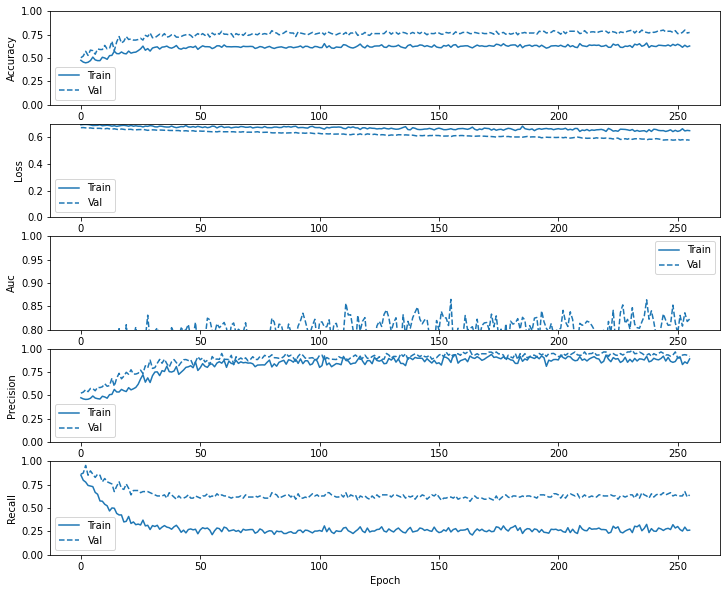

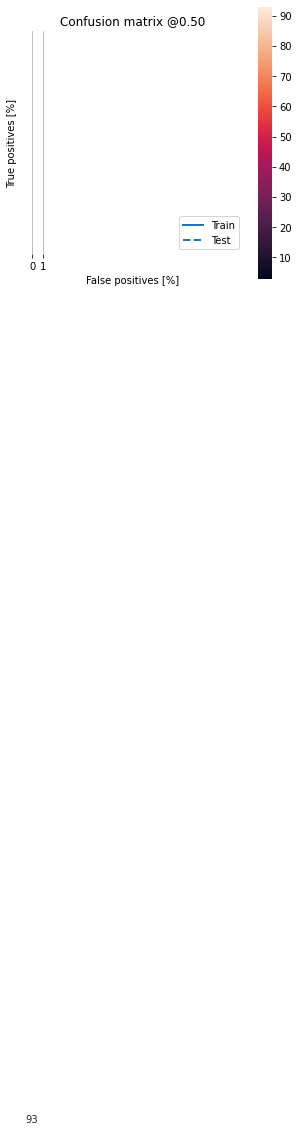

In [34]:
%%time
expId = 105
desc = str(expId) + " IQPEmbedding RandomLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.IQPEmbedding(inputs, wires=range(n_qubits))
    qml.templates.RandomLayers(weights, wires=range(n_qubits))   
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model_105, history_105 = runTheExperiments(expId, desc)

Epoch 1/10000
13/13 [==============================] - 1048s 81s/step - loss: 0.7379 - tp: 228.7143 - fp: 190.2857 - tn: 96.2143 - fn: 53.6429 - accuracy: 0.5890 - precision: 0.5693 - recall: 0.7964 - auc: 0.5843 - val_loss: 0.7054 - val_tp: 83.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 3.0000 - val_accuracy: 0.5220 - val_precision: 0.5321 - val_recall: 0.9651 - val_auc: 0.5181
Epoch 2/10000
13/13 [==============================] - 1051s 81s/step - loss: 0.7354 - tp: 159.2857 - fp: 188.5714 - tn: 3.3571 - fn: 18.6429 - accuracy: 0.4356 - precision: 0.4514 - recall: 0.8985 - auc: 0.4844 - val_loss: 0.6979 - val_tp: 84.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 2.0000 - val_accuracy: 0.5283 - val_precision: 0.5350 - val_recall: 0.9767 - val_auc: 0.5507
Epoch 3/10000
13/13 [==============================] - 1050s 81s/step - loss: 0.7333 - tp: 162.1429 - fp: 191.4286 - tn: 2.3571 - fn: 13.9286 - accuracy: 0.4390 - precision: 0.4498 - recall: 0.9316 - auc: 0.4474 - val

Epoch 22/10000
13/13 [==============================] - 1050s 81s/step - loss: 0.6878 - tp: 144.1429 - fp: 155.3571 - tn: 32.2143 - fn: 38.1429 - accuracy: 0.4814 - precision: 0.4885 - recall: 0.7939 - auc: 0.5959 - val_loss: 0.6387 - val_tp: 79.0000 - val_fp: 59.0000 - val_tn: 14.0000 - val_fn: 7.0000 - val_accuracy: 0.5849 - val_precision: 0.5725 - val_recall: 0.9186 - val_auc: 0.7509
Epoch 23/10000
13/13 [==============================] - 1051s 81s/step - loss: 0.6837 - tp: 138.5714 - fp: 131.0714 - tn: 57.3571 - fn: 42.8571 - accuracy: 0.5352 - precision: 0.5202 - recall: 0.7824 - auc: 0.6604 - val_loss: 0.6358 - val_tp: 75.0000 - val_fp: 53.0000 - val_tn: 20.0000 - val_fn: 11.0000 - val_accuracy: 0.5975 - val_precision: 0.5859 - val_recall: 0.8721 - val_auc: 0.7845
Epoch 24/10000
13/13 [==============================] - 1050s 81s/step - loss: 0.6846 - tp: 127.8571 - fp: 136.2143 - tn: 57.5000 - fn: 48.2857 - accuracy: 0.5123 - precision: 0.4953 - recall: 0.7427 - auc: 0.6416 - val

13/13 [==============================] - 1049s 81s/step - loss: 0.6716 - tp: 56.2143 - fp: 6.2857 - tn: 185.5000 - fn: 121.8571 - accuracy: 0.6534 - precision: 0.9162 - recall: 0.3054 - auc: 0.6953 - val_loss: 0.6240 - val_tp: 50.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 36.0000 - val_accuracy: 0.7358 - val_precision: 0.8929 - val_recall: 0.5814 - val_auc: 0.7870
Epoch 44/10000
13/13 [==============================] - 1050s 81s/step - loss: 0.6689 - tp: 64.9286 - fp: 6.4286 - tn: 186.8571 - fn: 111.6429 - accuracy: 0.6899 - precision: 0.8949 - recall: 0.3840 - auc: 0.6648 - val_loss: 0.6232 - val_tp: 49.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 37.0000 - val_accuracy: 0.7421 - val_precision: 0.9245 - val_recall: 0.5698 - val_auc: 0.7731
Epoch 45/10000
13/13 [==============================] - 1049s 81s/step - loss: 0.6659 - tp: 69.2143 - fp: 8.7143 - tn: 182.5714 - fn: 109.3571 - accuracy: 0.6753 - precision: 0.8858 - recall: 0.3801 - auc: 0.6660 - val_loss: 0.6213 - val

13/13 [==============================] - 1051s 81s/step - loss: 0.6515 - tp: 56.8571 - fp: 3.8571 - tn: 187.7857 - fn: 121.3571 - accuracy: 0.6455 - precision: 0.9216 - recall: 0.2956 - auc: 0.6326 - val_loss: 0.6014 - val_tp: 50.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 36.0000 - val_accuracy: 0.7358 - val_precision: 0.8929 - val_recall: 0.5814 - val_auc: 0.7513
Epoch 65/10000
13/13 [==============================] - 1051s 81s/step - loss: 0.6472 - tp: 56.0000 - fp: 4.1429 - tn: 187.4286 - fn: 122.2857 - accuracy: 0.6600 - precision: 0.9379 - recall: 0.3140 - auc: 0.6178 - val_loss: 0.5965 - val_tp: 49.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 37.0000 - val_accuracy: 0.7484 - val_precision: 0.9423 - val_recall: 0.5698 - val_auc: 0.7761
Epoch 66/10000
13/13 [==============================] - 1053s 81s/step - loss: 0.6366 - tp: 68.0714 - fp: 4.0000 - tn: 188.6429 - fn: 109.1429 - accuracy: 0.7055 - precision: 0.9462 - recall: 0.4039 - auc: 0.6603 - val_loss: 0.5942 - val

13/13 [==============================] - 1051s 81s/step - loss: 0.6292 - tp: 55.8571 - fp: 4.3571 - tn: 189.2857 - fn: 120.3571 - accuracy: 0.6536 - precision: 0.8968 - recall: 0.2917 - auc: 0.5882 - val_loss: 0.5756 - val_tp: 48.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 38.0000 - val_accuracy: 0.7484 - val_precision: 0.9600 - val_recall: 0.5581 - val_auc: 0.7834
Epoch 86/10000
13/13 [==============================] - 1051s 81s/step - loss: 0.6266 - tp: 58.8571 - fp: 5.7143 - tn: 180.2143 - fn: 125.0714 - accuracy: 0.6356 - precision: 0.8993 - recall: 0.3119 - auc: 0.5924 - val_loss: 0.5730 - val_tp: 49.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 37.0000 - val_accuracy: 0.7547 - val_precision: 0.9608 - val_recall: 0.5698 - val_auc: 0.7733
Epoch 87/10000
13/13 [==============================] - 1052s 81s/step - loss: 0.6134 - tp: 61.5714 - fp: 5.2857 - tn: 184.3571 - fn: 118.6429 - accuracy: 0.6711 - precision: 0.9223 - recall: 0.3587 - auc: 0.6121 - val_loss: 0.5749 - val

13/13 [==============================] - 1047s 81s/step - loss: 0.6004 - tp: 67.7857 - fp: 6.2143 - tn: 181.6429 - fn: 114.2143 - accuracy: 0.6647 - precision: 0.9171 - recall: 0.3661 - auc: 0.6468 - val_loss: 0.5611 - val_tp: 50.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 36.0000 - val_accuracy: 0.7484 - val_precision: 0.9259 - val_recall: 0.5814 - val_auc: 0.7664
Epoch 107/10000
13/13 [==============================] - 1052s 81s/step - loss: 0.6188 - tp: 61.3571 - fp: 7.7857 - tn: 181.2143 - fn: 119.5000 - accuracy: 0.6555 - precision: 0.8872 - recall: 0.3280 - auc: 0.6127 - val_loss: 0.5571 - val_tp: 50.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 36.0000 - val_accuracy: 0.7610 - val_precision: 0.9615 - val_recall: 0.5814 - val_auc: 0.8080
Epoch 108/10000
13/13 [==============================] - 1049s 81s/step - loss: 0.6020 - tp: 66.2143 - fp: 9.1429 - tn: 180.4286 - fn: 114.0714 - accuracy: 0.6622 - precision: 0.8472 - recall: 0.3757 - auc: 0.6466 - val_loss: 0.5594 - v

13/13 [==============================] - 1049s 81s/step - loss: 0.6085 - tp: 58.3571 - fp: 9.7857 - tn: 176.9286 - fn: 124.7857 - accuracy: 0.6325 - precision: 0.8749 - recall: 0.3226 - auc: 0.5838 - val_loss: 0.5529 - val_tp: 49.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 37.0000 - val_accuracy: 0.7547 - val_precision: 0.9608 - val_recall: 0.5698 - val_auc: 0.7961
Epoch 128/10000
13/13 [==============================] - 1050s 81s/step - loss: 0.6040 - tp: 56.9286 - fp: 6.9286 - tn: 183.3571 - fn: 122.6429 - accuracy: 0.6445 - precision: 0.8889 - recall: 0.3179 - auc: 0.6640 - val_loss: 0.5514 - val_tp: 50.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 36.0000 - val_accuracy: 0.7610 - val_precision: 0.9615 - val_recall: 0.5814 - val_auc: 0.7866
Epoch 129/10000
13/13 [==============================] - 1050s 81s/step - loss: 0.6134 - tp: 57.4286 - fp: 4.9286 - tn: 179.5714 - fn: 127.9286 - accuracy: 0.6282 - precision: 0.9256 - recall: 0.3048 - auc: 0.6393 - val_loss: 0.5463 - v

13/13 [==============================] - 1051s 81s/step - loss: 0.5892 - tp: 58.9286 - fp: 6.2857 - tn: 185.3571 - fn: 119.2857 - accuracy: 0.6612 - precision: 0.9103 - recall: 0.3308 - auc: 0.6724 - val_loss: 0.5372 - val_tp: 50.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 36.0000 - val_accuracy: 0.7610 - val_precision: 0.9615 - val_recall: 0.5814 - val_auc: 0.8154
Epoch 149/10000
13/13 [==============================] - 1048s 81s/step - loss: 0.6121 - tp: 60.2857 - fp: 8.5714 - tn: 178.0714 - fn: 122.9286 - accuracy: 0.6242 - precision: 0.8542 - recall: 0.3048 - auc: 0.6489 - val_loss: 0.5355 - val_tp: 49.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 37.0000 - val_accuracy: 0.7547 - val_precision: 0.9608 - val_recall: 0.5698 - val_auc: 0.8187
Epoch 150/10000
13/13 [==============================] - 1050s 81s/step - loss: 0.5903 - tp: 55.2857 - fp: 2.9286 - tn: 193.6429 - fn: 118.0000 - accuracy: 0.6832 - precision: 0.9608 - recall: 0.3312 - auc: 0.6345 - val_loss: 0.5394 - v

13/13 [==============================] - 1053s 81s/step - loss: 0.5877 - tp: 60.3571 - fp: 2.7857 - tn: 188.2143 - fn: 118.5000 - accuracy: 0.6668 - precision: 0.9710 - recall: 0.3320 - auc: 0.6698 - val_loss: 0.5274 - val_tp: 50.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 36.0000 - val_accuracy: 0.7610 - val_precision: 0.9615 - val_recall: 0.5814 - val_auc: 0.8402
Epoch 170/10000
13/13 [==============================] - 1050s 81s/step - loss: 0.5836 - tp: 62.5714 - fp: 7.0714 - tn: 187.2857 - fn: 112.9286 - accuracy: 0.6771 - precision: 0.8795 - recall: 0.3584 - auc: 0.6456 - val_loss: 0.5300 - val_tp: 50.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 36.0000 - val_accuracy: 0.7547 - val_precision: 0.9434 - val_recall: 0.5814 - val_auc: 0.8266
Epoch 171/10000
13/13 [==============================] - 1049s 81s/step - loss: 0.5705 - tp: 66.6429 - fp: 4.6429 - tn: 189.8571 - fn: 108.7143 - accuracy: 0.6957 - precision: 0.9397 - recall: 0.3813 - auc: 0.6594 - val_loss: 0.5297 - v

13/13 [==============================] - 1052s 81s/step - loss: 0.5697 - tp: 64.4286 - fp: 6.8571 - tn: 190.2857 - fn: 108.2857 - accuracy: 0.6968 - precision: 0.8949 - recall: 0.3930 - auc: 0.6811 - val_loss: 0.5290 - val_tp: 50.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 36.0000 - val_accuracy: 0.7610 - val_precision: 0.9615 - val_recall: 0.5814 - val_auc: 0.7862
Epoch 191/10000
13/13 [==============================] - 1053s 81s/step - loss: 0.5880 - tp: 60.2143 - fp: 6.6429 - tn: 186.3571 - fn: 116.6429 - accuracy: 0.6671 - precision: 0.8972 - recall: 0.3405 - auc: 0.6256 - val_loss: 0.5246 - val_tp: 50.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 36.0000 - val_accuracy: 0.7610 - val_precision: 0.9615 - val_recall: 0.5814 - val_auc: 0.8007
Epoch 192/10000
13/13 [==============================] - 1052s 81s/step - loss: 0.5850 - tp: 62.3571 - fp: 8.6429 - tn: 185.7143 - fn: 113.1429 - accuracy: 0.6755 - precision: 0.8831 - recall: 0.3565 - auc: 0.6434 - val_loss: 0.5244 - v

13/13 [==============================] - 988s 76s/step - loss: 0.5925 - tp: 57.4286 - fp: 1.7143 - tn: 189.4286 - fn: 121.2857 - accuracy: 0.6666 - precision: 0.9805 - recall: 0.3164 - auc: 0.6393 - val_loss: 0.5242 - val_tp: 51.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 35.0000 - val_accuracy: 0.7673 - val_precision: 0.9623 - val_recall: 0.5930 - val_auc: 0.8060
Epoch 212/10000
13/13 [==============================] - 970s 75s/step - loss: 0.6006 - tp: 54.2857 - fp: 7.6429 - tn: 185.7857 - fn: 122.1429 - accuracy: 0.6498 - precision: 0.8878 - recall: 0.3101 - auc: 0.5954 - val_loss: 0.5255 - val_tp: 51.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 35.0000 - val_accuracy: 0.7610 - val_precision: 0.9444 - val_recall: 0.5930 - val_auc: 0.8191
Epoch 213/10000
13/13 [==============================] - 970s 75s/step - loss: 0.5787 - tp: 65.7857 - fp: 6.2143 - tn: 185.0714 - fn: 112.7857 - accuracy: 0.6814 - precision: 0.9168 - recall: 0.3671 - auc: 0.6439 - val_loss: 0.5236 - val_

13/13 [==============================] - 969s 75s/step - loss: 0.5705 - tp: 59.5000 - fp: 4.9286 - tn: 192.2857 - fn: 113.1429 - accuracy: 0.6918 - precision: 0.9287 - recall: 0.3655 - auc: 0.6789 - val_loss: 0.5273 - val_tp: 50.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 36.0000 - val_accuracy: 0.7610 - val_precision: 0.9615 - val_recall: 0.5814 - val_auc: 0.8167
Epoch 233/10000
13/13 [==============================] - 968s 74s/step - loss: 0.6055 - tp: 50.3571 - fp: 5.0000 - tn: 186.6429 - fn: 127.8571 - accuracy: 0.6416 - precision: 0.9006 - recall: 0.2754 - auc: 0.6471 - val_loss: 0.5327 - val_tp: 50.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 36.0000 - val_accuracy: 0.7484 - val_precision: 0.9259 - val_recall: 0.5814 - val_auc: 0.7905
Epoch 234/10000
13/13 [==============================] - 970s 75s/step - loss: 0.5921 - tp: 51.9286 - fp: 2.3571 - tn: 191.1429 - fn: 124.4286 - accuracy: 0.6661 - precision: 0.9595 - recall: 0.2923 - auc: 0.6641 - val_loss: 0.5299 - val_

13/13 [==============================] - 970s 75s/step - loss: 0.5745 - tp: 67.5000 - fp: 4.3571 - tn: 189.4286 - fn: 108.5714 - accuracy: 0.7026 - precision: 0.9373 - recall: 0.3939 - auc: 0.7207 - val_loss: 0.5339 - val_tp: 50.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 36.0000 - val_accuracy: 0.7610 - val_precision: 0.9615 - val_recall: 0.5814 - val_auc: 0.7898
Epoch 254/10000
13/13 [==============================] - 973s 75s/step - loss: 0.5775 - tp: 70.2143 - fp: 3.9286 - tn: 186.0000 - fn: 109.7143 - accuracy: 0.6994 - precision: 0.9478 - recall: 0.3945 - auc: 0.7205 - val_loss: 0.5325 - val_tp: 51.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 35.0000 - val_accuracy: 0.7610 - val_precision: 0.9444 - val_recall: 0.5930 - val_auc: 0.7932
Epoch 255/10000
13/13 [==============================] - 971s 75s/step - loss: 0.5723 - tp: 69.5714 - fp: 5.0000 - tn: 184.5714 - fn: 110.7143 - accuracy: 0.6924 - precision: 0.9389 - recall: 0.3910 - auc: 0.7322 - val_loss: 0.5331 - val_

13/13 [==============================] - 973s 75s/step - loss: 0.5690 - tp: 72.7857 - fp: 5.2857 - tn: 193.4286 - fn: 98.3571 - accuracy: 0.7368 - precision: 0.9157 - recall: 0.4438 - auc: 0.7505 - val_loss: 0.5262 - val_tp: 50.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 36.0000 - val_accuracy: 0.7610 - val_precision: 0.9615 - val_recall: 0.5814 - val_auc: 0.7692
Epoch 275/10000
13/13 [==============================] - 971s 75s/step - loss: 0.5685 - tp: 77.7857 - fp: 7.1429 - tn: 183.9286 - fn: 101.0000 - accuracy: 0.7134 - precision: 0.9157 - recall: 0.4503 - auc: 0.7393 - val_loss: 0.5204 - val_tp: 50.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 36.0000 - val_accuracy: 0.7610 - val_precision: 0.9615 - val_recall: 0.5814 - val_auc: 0.8182
Epoch 276/10000
13/13 [==============================] - 970s 75s/step - loss: 0.5967 - tp: 72.9286 - fp: 3.9286 - tn: 185.2857 - fn: 107.7143 - accuracy: 0.6896 - precision: 0.9432 - recall: 0.3913 - auc: 0.7034 - val_loss: 0.5208 - val_t

13/13 [==============================] - 933s 72s/step - loss: 0.5572 - tp: 90.7857 - fp: 7.7857 - tn: 181.3571 - fn: 89.9286 - accuracy: 0.7424 - precision: 0.9073 - recall: 0.5260 - auc: 0.7545 - val_loss: 0.5178 - val_tp: 50.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 36.0000 - val_accuracy: 0.7610 - val_precision: 0.9615 - val_recall: 0.5814 - val_auc: 0.7948
Epoch 296/10000
13/13 [==============================] - 932s 72s/step - loss: 0.5754 - tp: 82.3571 - fp: 6.0714 - tn: 185.2143 - fn: 96.2143 - accuracy: 0.7213 - precision: 0.9272 - recall: 0.4625 - auc: 0.7782 - val_loss: 0.5181 - val_tp: 50.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 36.0000 - val_accuracy: 0.7610 - val_precision: 0.9615 - val_recall: 0.5814 - val_auc: 0.8151
Epoch 297/10000
13/13 [==============================] - 935s 72s/step - loss: 0.5709 - tp: 77.5000 - fp: 6.0714 - tn: 186.5000 - fn: 99.7857 - accuracy: 0.7105 - precision: 0.9244 - recall: 0.4358 - auc: 0.7050 - val_loss: 0.5173 - val_tp:

13/13 [==============================] - 933s 72s/step - loss: 0.5693 - tp: 85.2857 - fp: 5.0714 - tn: 185.3571 - fn: 94.1429 - accuracy: 0.7216 - precision: 0.9331 - recall: 0.4726 - auc: 0.7084 - val_loss: 0.5191 - val_tp: 50.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 36.0000 - val_accuracy: 0.7610 - val_precision: 0.9615 - val_recall: 0.5814 - val_auc: 0.8089
Epoch 317/10000
13/13 [==============================] - 935s 72s/step - loss: 0.5368 - tp: 87.2857 - fp: 1.5000 - tn: 192.2857 - fn: 88.7857 - accuracy: 0.7628 - precision: 0.9889 - recall: 0.4992 - auc: 0.7763 - val_loss: 0.5202 - val_tp: 50.0000 - val_fp: 1.0000 - val_tn: 72.0000 - val_fn: 36.0000 - val_accuracy: 0.7673 - val_precision: 0.9804 - val_recall: 0.5814 - val_auc: 0.8213
Epoch 318/10000
13/13 [==============================] - 934s 72s/step - loss: 0.5590 - tp: 85.9286 - fp: 4.0714 - tn: 190.6429 - fn: 89.2143 - accuracy: 0.7494 - precision: 0.9627 - recall: 0.4938 - auc: 0.7224 - val_loss: 0.5187 - val_tp:

13/13 [==============================] - 934s 72s/step - loss: 0.5728 - tp: 72.2143 - fp: 5.2857 - tn: 194.6429 - fn: 97.7143 - accuracy: 0.7204 - precision: 0.9227 - recall: 0.4163 - auc: 0.7192 - val_loss: 0.5190 - val_tp: 52.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 34.0000 - val_accuracy: 0.7736 - val_precision: 0.9630 - val_recall: 0.6047 - val_auc: 0.8042
Epoch 338/10000
13/13 [==============================] - 932s 72s/step - loss: 0.5750 - tp: 72.8571 - fp: 4.9286 - tn: 191.5000 - fn: 100.5714 - accuracy: 0.7181 - precision: 0.9409 - recall: 0.4117 - auc: 0.7205 - val_loss: 0.5163 - val_tp: 50.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 36.0000 - val_accuracy: 0.7610 - val_precision: 0.9615 - val_recall: 0.5814 - val_auc: 0.8209
Epoch 339/10000
13/13 [==============================] - 935s 72s/step - loss: 0.5467 - tp: 92.5000 - fp: 4.9286 - tn: 183.7143 - fn: 88.7143 - accuracy: 0.7447 - precision: 0.9520 - recall: 0.5169 - auc: 0.7403 - val_loss: 0.5182 - val_tp

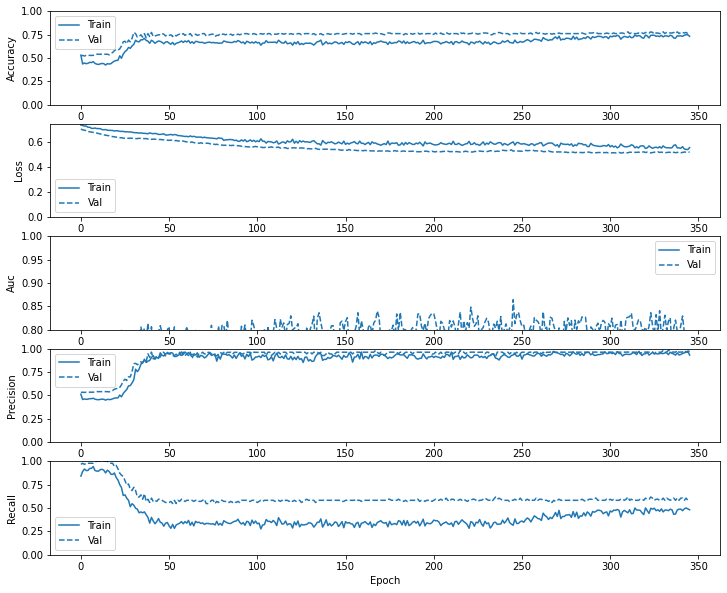

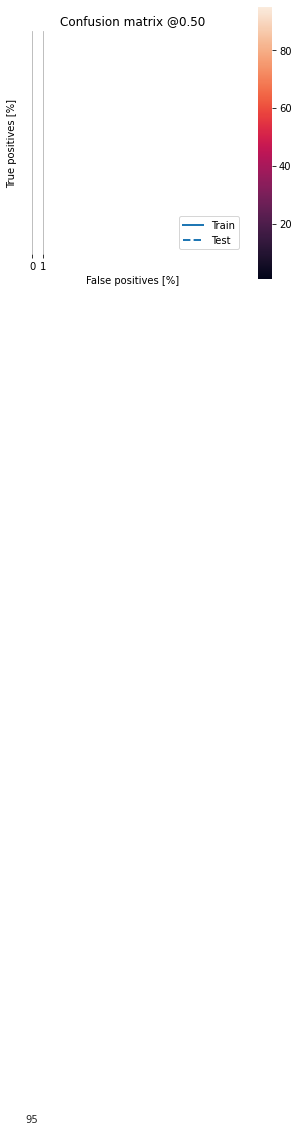

In [35]:
%%time
expId = 106
desc = str(expId) + " IQPEmbedding StronglyEntanglingLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.IQPEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))    
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, {"weights": (n_layers, n_qubits, 3)}, output_dim=n_qubits)

model_106, history_106 = runTheExperiments(expId, desc)

# Save Data For Comparisons

In [36]:
#np.savetxt(results_folder + "n" + str(num_data) + "_train_labels.csv", train_labels, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_val_labels.csv", val_labels, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_test_labels.csv", test_labels, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_train_features.csv", train_features, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_val_features.csv", val_features, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_test_features.csv", test_features, delimiter=",")


# Experiments B - Classical Deep Learning

In [37]:
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          2, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  model.summary()

  return model
  
 

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 2)                 10        
_________________________________________________________________
dropout_7 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 3         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10000
13/13 [==============================] - 2s 62ms/step - loss: 0.7625 - tp: 243.3571 - fp: 191.5000 - tn: 95.0000 - fn: 39.0000 - accuracy: 0.6111 - precision: 0.5838 - recall: 0.8413 - auc: 0.7062 - val_loss: 0.6958 - val_tp: 86.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5409 - val_precision: 0.5409 - val_recall: 1.0000 - val_auc: 0

13/13 [==============================] - 0s 8ms/step - loss: 0.5852 - tp: 90.2143 - fp: 25.1429 - tn: 164.6429 - fn: 89.8571 - accuracy: 0.6808 - precision: 0.7566 - recall: 0.4801 - auc: 0.6929 - val_loss: 0.5386 - val_tp: 55.0000 - val_fp: 18.0000 - val_tn: 55.0000 - val_fn: 31.0000 - val_accuracy: 0.6918 - val_precision: 0.7534 - val_recall: 0.6395 - val_auc: 0.7721
Epoch 21/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.5588 - tp: 101.3571 - fp: 21.2857 - tn: 166.9286 - fn: 80.2857 - accuracy: 0.7244 - precision: 0.8202 - recall: 0.5597 - auc: 0.7397 - val_loss: 0.5362 - val_tp: 55.0000 - val_fp: 17.0000 - val_tn: 56.0000 - val_fn: 31.0000 - val_accuracy: 0.6981 - val_precision: 0.7639 - val_recall: 0.6395 - val_auc: 0.7746
Epoch 22/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.5682 - tp: 94.8571 - fp: 24.6429 - tn: 162.9286 - fn: 87.4286 - accuracy: 0.6909 - precision: 0.8021 - recall: 0.5086 - auc: 0.7145 - val_loss: 0.5340 - val_tp: 5

13/13 [==============================] - 0s 9ms/step - loss: 0.5660 - tp: 80.9286 - fp: 12.0000 - tn: 178.7143 - fn: 98.2143 - accuracy: 0.6912 - precision: 0.8810 - recall: 0.4385 - auc: 0.7005 - val_loss: 0.5061 - val_tp: 52.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 34.0000 - val_accuracy: 0.7421 - val_precision: 0.8814 - val_recall: 0.6047 - val_auc: 0.8072
Epoch 42/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.5269 - tp: 93.5000 - fp: 10.1429 - tn: 187.4286 - fn: 78.7857 - accuracy: 0.7625 - precision: 0.8982 - recall: 0.5400 - auc: 0.7528 - val_loss: 0.5050 - val_tp: 52.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 34.0000 - val_accuracy: 0.7421 - val_precision: 0.8814 - val_recall: 0.6047 - val_auc: 0.8072
Epoch 43/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.5364 - tp: 90.8571 - fp: 9.4286 - tn: 182.3571 - fn: 87.2143 - accuracy: 0.7412 - precision: 0.9068 - recall: 0.5128 - auc: 0.7465 - val_loss: 0.5038 - val_tp: 52.00

13/13 [==============================] - 0s 8ms/step - loss: 0.5181 - tp: 96.2857 - fp: 7.2143 - tn: 181.9286 - fn: 84.4286 - accuracy: 0.7485 - precision: 0.9248 - recall: 0.5244 - auc: 0.7712 - val_loss: 0.4796 - val_tp: 52.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 34.0000 - val_accuracy: 0.7484 - val_precision: 0.8966 - val_recall: 0.6047 - val_auc: 0.8652
Epoch 63/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.5339 - tp: 88.7857 - fp: 10.7143 - tn: 183.7857 - fn: 86.5714 - accuracy: 0.7312 - precision: 0.8703 - recall: 0.4930 - auc: 0.7350 - val_loss: 0.4764 - val_tp: 52.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 34.0000 - val_accuracy: 0.7484 - val_precision: 0.8966 - val_recall: 0.6047 - val_auc: 0.8712
Epoch 64/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.5181 - tp: 100.5000 - fp: 9.9286 - tn: 181.7143 - fn: 77.7143 - accuracy: 0.7515 - precision: 0.9043 - recall: 0.5473 - auc: 0.7791 - val_loss: 0.4731 - val_tp: 52.00

13/13 [==============================] - 0s 8ms/step - loss: 0.5049 - tp: 102.5714 - fp: 10.1429 - tn: 177.1429 - fn: 80.0000 - accuracy: 0.7564 - precision: 0.9230 - recall: 0.5521 - auc: 0.7707 - val_loss: 0.4319 - val_tp: 67.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 19.0000 - val_accuracy: 0.8616 - val_precision: 0.9571 - val_recall: 0.7791 - val_auc: 0.9258
Epoch 84/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4909 - tp: 105.5714 - fp: 9.3571 - tn: 183.6429 - fn: 71.2857 - accuracy: 0.7799 - precision: 0.9219 - recall: 0.5929 - auc: 0.7799 - val_loss: 0.4308 - val_tp: 67.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 19.0000 - val_accuracy: 0.8616 - val_precision: 0.9571 - val_recall: 0.7791 - val_auc: 0.9256
Epoch 85/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.5103 - tp: 101.6429 - fp: 14.7857 - tn: 178.8571 - fn: 74.5714 - accuracy: 0.7571 - precision: 0.8698 - recall: 0.5682 - auc: 0.7789 - val_loss: 0.4300 - val_tp: 67

13/13 [==============================] - 0s 8ms/step - loss: 0.4999 - tp: 98.7857 - fp: 13.6429 - tn: 181.2143 - fn: 76.2143 - accuracy: 0.7516 - precision: 0.8747 - recall: 0.5604 - auc: 0.7652 - val_loss: 0.4131 - val_tp: 69.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 17.0000 - val_accuracy: 0.8742 - val_precision: 0.9583 - val_recall: 0.8023 - val_auc: 0.9427
Epoch 105/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4699 - tp: 104.1429 - fp: 9.0714 - tn: 186.5000 - fn: 70.1429 - accuracy: 0.7921 - precision: 0.9162 - recall: 0.5983 - auc: 0.7986 - val_loss: 0.4120 - val_tp: 69.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 17.0000 - val_accuracy: 0.8742 - val_precision: 0.9583 - val_recall: 0.8023 - val_auc: 0.9422
Epoch 106/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4587 - tp: 114.4286 - fp: 9.4286 - tn: 178.4286 - fn: 67.5714 - accuracy: 0.7945 - precision: 0.9279 - recall: 0.6386 - auc: 0.8136 - val_loss: 0.4110 - val_tp: 69

13/13 [==============================] - 0s 7ms/step - loss: 0.4707 - tp: 106.1429 - fp: 10.6429 - tn: 183.5000 - fn: 69.5714 - accuracy: 0.7846 - precision: 0.9082 - recall: 0.6026 - auc: 0.7957 - val_loss: 0.3976 - val_tp: 70.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 16.0000 - val_accuracy: 0.8805 - val_precision: 0.9589 - val_recall: 0.8140 - val_auc: 0.9517
Epoch 126/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4871 - tp: 101.5714 - fp: 9.5714 - tn: 184.5000 - fn: 74.2143 - accuracy: 0.7718 - precision: 0.9162 - recall: 0.5678 - auc: 0.7787 - val_loss: 0.3970 - val_tp: 70.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 16.0000 - val_accuracy: 0.8805 - val_precision: 0.9589 - val_recall: 0.8140 - val_auc: 0.9519
Epoch 127/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4686 - tp: 109.8571 - fp: 10.8571 - tn: 175.8571 - fn: 73.2857 - accuracy: 0.7731 - precision: 0.9158 - recall: 0.6082 - auc: 0.7921 - val_loss: 0.3966 - val_tp: 

13/13 [==============================] - 0s 8ms/step - loss: 0.4729 - tp: 105.0714 - fp: 11.2857 - tn: 176.5714 - fn: 76.9286 - accuracy: 0.7722 - precision: 0.9102 - recall: 0.5956 - auc: 0.7854 - val_loss: 0.3881 - val_tp: 71.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 15.0000 - val_accuracy: 0.8868 - val_precision: 0.9595 - val_recall: 0.8256 - val_auc: 0.9555
Epoch 147/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4436 - tp: 117.2857 - fp: 9.1429 - tn: 177.1429 - fn: 66.2857 - accuracy: 0.7931 - precision: 0.9307 - recall: 0.6358 - auc: 0.8138 - val_loss: 0.3872 - val_tp: 71.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 15.0000 - val_accuracy: 0.8868 - val_precision: 0.9595 - val_recall: 0.8256 - val_auc: 0.9552
Epoch 148/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4647 - tp: 111.3571 - fp: 10.4286 - tn: 181.2143 - fn: 66.8571 - accuracy: 0.7938 - precision: 0.9105 - recall: 0.6352 - auc: 0.8005 - val_loss: 0.3868 - val_tp: 

13/13 [==============================] - 0s 8ms/step - loss: 0.4598 - tp: 111.2143 - fp: 11.8571 - tn: 180.2857 - fn: 66.5000 - accuracy: 0.7834 - precision: 0.8912 - recall: 0.6170 - auc: 0.7963 - val_loss: 0.3794 - val_tp: 72.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 14.0000 - val_accuracy: 0.8931 - val_precision: 0.9600 - val_recall: 0.8372 - val_auc: 0.9572
Epoch 168/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.4683 - tp: 116.5000 - fp: 10.4286 - tn: 173.7857 - fn: 69.1429 - accuracy: 0.7736 - precision: 0.9248 - recall: 0.6202 - auc: 0.7996 - val_loss: 0.3789 - val_tp: 72.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 14.0000 - val_accuracy: 0.8931 - val_precision: 0.9600 - val_recall: 0.8372 - val_auc: 0.9572
Epoch 169/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4441 - tp: 111.0000 - fp: 9.2143 - tn: 181.7857 - fn: 67.8571 - accuracy: 0.7941 - precision: 0.9216 - recall: 0.6331 - auc: 0.8100 - val_loss: 0.3785 - val_tp: 

13/13 [==============================] - 0s 8ms/step - loss: 0.4906 - tp: 105.6429 - fp: 14.5714 - tn: 177.6429 - fn: 72.0000 - accuracy: 0.7612 - precision: 0.8689 - recall: 0.5823 - auc: 0.7758 - val_loss: 0.3709 - val_tp: 73.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 13.0000 - val_accuracy: 0.8931 - val_precision: 0.9481 - val_recall: 0.8488 - val_auc: 0.9618
Epoch 189/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4575 - tp: 112.7143 - fp: 7.8571 - tn: 182.7857 - fn: 66.5000 - accuracy: 0.7892 - precision: 0.9267 - recall: 0.6119 - auc: 0.8003 - val_loss: 0.3710 - val_tp: 73.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 13.0000 - val_accuracy: 0.8994 - val_precision: 0.9605 - val_recall: 0.8488 - val_auc: 0.9577
Epoch 190/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.4807 - tp: 99.7143 - fp: 9.8571 - tn: 187.2857 - fn: 73.0000 - accuracy: 0.7791 - precision: 0.9142 - recall: 0.5785 - auc: 0.7672 - val_loss: 0.3712 - val_tp: 73

13/13 [==============================] - 0s 8ms/step - loss: 0.4971 - tp: 109.2143 - fp: 9.5000 - tn: 177.8571 - fn: 73.2857 - accuracy: 0.7679 - precision: 0.9332 - recall: 0.5732 - auc: 0.7574 - val_loss: 0.3658 - val_tp: 73.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 13.0000 - val_accuracy: 0.8931 - val_precision: 0.9481 - val_recall: 0.8488 - val_auc: 0.9574
Epoch 210/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4841 - tp: 107.0714 - fp: 11.4286 - tn: 181.2857 - fn: 70.0714 - accuracy: 0.7730 - precision: 0.8983 - recall: 0.5835 - auc: 0.7749 - val_loss: 0.3670 - val_tp: 73.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 13.0000 - val_accuracy: 0.8994 - val_precision: 0.9605 - val_recall: 0.8488 - val_auc: 0.9578
Epoch 211/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4637 - tp: 107.4286 - fp: 6.3571 - tn: 184.7857 - fn: 71.2857 - accuracy: 0.7944 - precision: 0.9506 - recall: 0.6052 - auc: 0.7983 - val_loss: 0.3673 - val_tp: 7

13/13 [==============================] - 0s 8ms/step - loss: 0.4069 - tp: 121.4286 - fp: 7.7857 - tn: 182.0000 - fn: 58.6429 - accuracy: 0.8224 - precision: 0.9351 - recall: 0.6822 - auc: 0.8413 - val_loss: 0.3617 - val_tp: 73.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 13.0000 - val_accuracy: 0.8994 - val_precision: 0.9605 - val_recall: 0.8488 - val_auc: 0.9578
Epoch 231/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.4973 - tp: 112.2143 - fp: 9.7143 - tn: 173.6429 - fn: 74.2857 - accuracy: 0.7510 - precision: 0.9103 - recall: 0.5912 - auc: 0.7740 - val_loss: 0.3616 - val_tp: 72.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 14.0000 - val_accuracy: 0.8931 - val_precision: 0.9600 - val_recall: 0.8372 - val_auc: 0.9574
Epoch 232/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4703 - tp: 100.5000 - fp: 8.1429 - tn: 189.0714 - fn: 72.1429 - accuracy: 0.7842 - precision: 0.9309 - recall: 0.5800 - auc: 0.7830 - val_loss: 0.3616 - val_tp: 72

13/13 [==============================] - 0s 8ms/step - loss: 0.4414 - tp: 114.9286 - fp: 8.5000 - tn: 180.5000 - fn: 65.9286 - accuracy: 0.7961 - precision: 0.9341 - recall: 0.6347 - auc: 0.8142 - val_loss: 0.3618 - val_tp: 72.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 14.0000 - val_accuracy: 0.8931 - val_precision: 0.9600 - val_recall: 0.8372 - val_auc: 0.9580
Epoch 252/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.4502 - tp: 105.7857 - fp: 10.0000 - tn: 186.3571 - fn: 67.7143 - accuracy: 0.7960 - precision: 0.9143 - recall: 0.6120 - auc: 0.8052 - val_loss: 0.3612 - val_tp: 72.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 14.0000 - val_accuracy: 0.8931 - val_precision: 0.9600 - val_recall: 0.8372 - val_auc: 0.9581
Epoch 253/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4419 - tp: 110.5714 - fp: 7.0714 - tn: 186.7143 - fn: 65.5000 - accuracy: 0.8076 - precision: 0.9355 - recall: 0.6337 - auc: 0.8044 - val_loss: 0.3606 - val_tp: 7

13/13 [==============================] - 0s 7ms/step - loss: 0.4613 - tp: 107.5714 - fp: 8.0000 - tn: 181.5714 - fn: 72.7143 - accuracy: 0.7856 - precision: 0.9415 - recall: 0.5986 - auc: 0.7898 - val_loss: 0.3575 - val_tp: 72.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 14.0000 - val_accuracy: 0.8931 - val_precision: 0.9600 - val_recall: 0.8372 - val_auc: 0.9584
Epoch 273/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4732 - tp: 101.6429 - fp: 9.0714 - tn: 187.4286 - fn: 71.7143 - accuracy: 0.7831 - precision: 0.9363 - recall: 0.5774 - auc: 0.7733 - val_loss: 0.3581 - val_tp: 72.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 14.0000 - val_accuracy: 0.8931 - val_precision: 0.9600 - val_recall: 0.8372 - val_auc: 0.9583
Epoch 274/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4307 - tp: 107.6429 - fp: 6.3571 - tn: 192.3571 - fn: 63.5000 - accuracy: 0.8179 - precision: 0.9347 - recall: 0.6267 - auc: 0.8180 - val_loss: 0.3586 - val_tp: 72

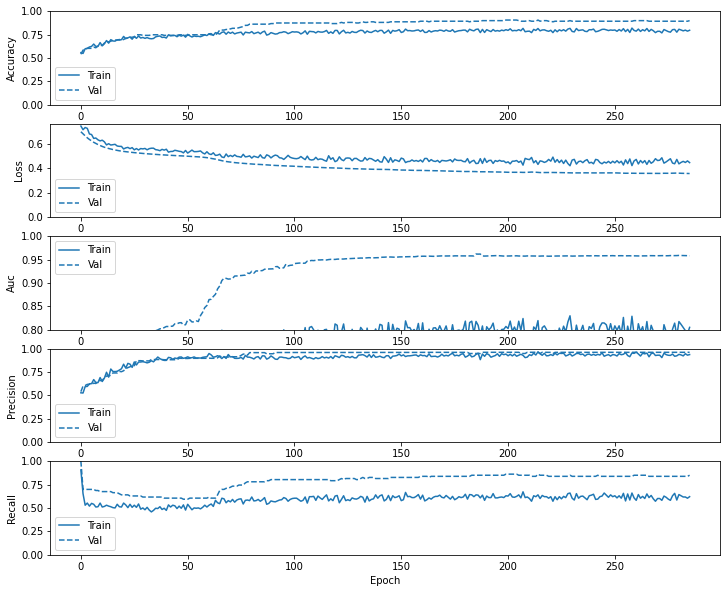

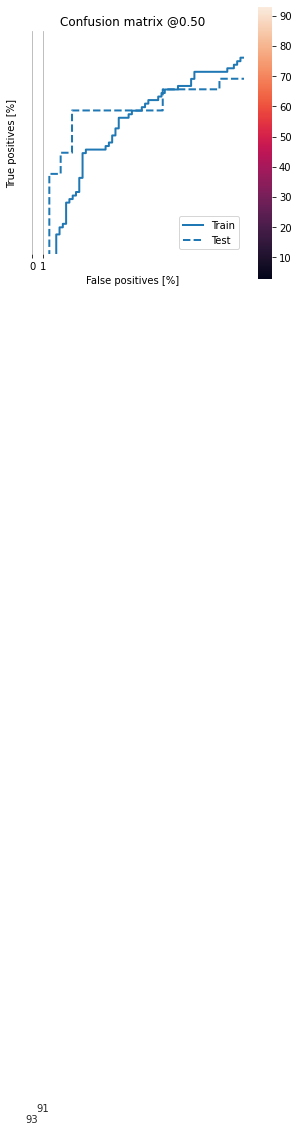

In [38]:
%%time
expId = 201
desc = str(expId) + " Classical Deep Learning" 

model_201, history_201 = runTheExperiments(expId, desc)


In [39]:
f.write("19_BotnetDga_Benchmarks - CPU n100 1layer - Device Noise Model ibmqx2 - qiskit.aer - seed 123")
f.flush()